
#  FEATURE ENGINEERING AND MODEL DEVELOPMENT

In this notebook, we 
1. Engineer features to model major components of the time series( trends and seasons) and 
2. Build forecasting models 

There are 2 things we must establish before designing forecasting models: 
1. **Available information at the time a forecast is made(features):** 
- In this case: store number, product family, onpromotion, some extra features like holidays and date index(time features can be derived from )
- this can help us avoid a type of data leakage called Lookahead leakage aka "peeking into the future" where info from future is inadvertently used to make predictions in the present.
-  This can happen when features or data that would not be available at the time of prediction are used to train a model. oil price be may an example if we assume that at a point of prediction, 
oil price for the following day is not known. 

2. **The time period during which you require forecasted values(forecast horizon):**
- this can help us make decision on what data to use during training or even the number of lag features to use. 
- we can't add lag features back further than the forecast horizon
- In this case: it's a short-term horizon, just a day into the future. so we can't add lag 2 feature in our model, for example. 

In [195]:
# importations
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_log_error
from sklearn.preprocessing import OneHotEncoder
from datetime import datetime, timedelta

from xgboost import XGBRegressor

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf


## Load Data

In [38]:
## Load datasets
store_sales = pd.read_csv("../data/raw/train.csv", 
                   dtype={
                       "store_nbr":"category", 
                       "family":"category",
                       "sales":"float64",
                        "id":"int32",
                        "onpromotion":"int32"
                       }, 
                   parse_dates=["date"], index_col=False)

holiday_events = pd.read_csv("../data/raw/holiday_events.csv", 
                    dtype={
                        "type":"category",
                        "locale":"category",
                        "locale_name":"category",
                        "description":"category",
                        "transferred":bool
                    },
                    index_col=["date"], 
                    parse_dates=True, 
                    date_format="%Y-%m-%d")
holiday_events = holiday_events.drop(columns=holiday_events.columns[0])

oil = pd.read_csv("../data/processed/01_oil_further_analysis.csv", 
                    index_col=["date"], parse_dates=True, 
                    date_format="%Y-%m-%d" )

stores = pd.read_csv("../data/raw/stores.csv", 
                     dtype={"store_nbr":"category", 
                            "city":"category",
                            "state":"category",
                            "type":"category",
                            "cluster":"category"
                            },
                     index_col=0)

In [41]:
store_sales["date"] = store_sales.date.dt.to_period("D") # change DatetimeIndex to PeriodIndex
store_sales = store_sales.set_index(["store_nbr", "family", "date"]).sort_index()
store_sales

id      sales  onpromotion
store_nbr family     date                                       
1         AUTOMOTIVE 2013-01-01        0   0.000000            0
                     2013-01-02     1782   2.000000            0
                     2013-01-03     3564   3.000000            0
                     2013-01-04     5346   3.000000            0
                     2013-01-05     7128   5.000000            0
...                                  ...        ...          ...
9         SEAFOOD    2017-08-11  2993759  23.831000            0
                     2017-08-12  2995541  16.859001            4
                     2017-08-13  2997323  20.000000            0
                     2017-08-14  2999105  17.000000            0
                     2017-08-15  3000887  16.000000            0

[3000888 rows x 3 columns]

In [326]:
store_nbr = "1"
family = "AUTOMOTIVE"

store_sales.loc[(store_nbr, family, slice(None))]

id  sales  onpromotion
date                                   
2013-01-01        0    0.0            0
2013-01-02     1782    2.0            0
2013-01-03     3564    3.0            0
2013-01-04     5346    3.0            0
2013-01-05     7128    5.0            0
...             ...    ...          ...
2017-08-11  2991978    1.0            0
2017-08-12  2993760    6.0            0
2017-08-13  2995542    1.0            0
2017-08-14  2997324    1.0            0
2017-08-15  2999106    4.0            0

[1684 rows x 3 columns]

- visualizing the sales series across all series is impractical as there are about 1800 series (store-family combinations) 
- to identiy common trends and patterns across different store-famiy combinations, we do an aggregated analysis using average daily sales 
- this can be useful for understanding the overall market trends seasonalities, or other shared characteristics. 
- once we have gained insights from the aggregated data, we perform feature engineering to capture these patterns 
- trade-off here is that we may lose some granularity and the ability to capture nuances specific to individual series. It's a balance between simplicity and detail

In [329]:
## average sales
average_sales = store_sales.groupby("date")["sales"].mean()
average_sales

date
2013-01-01      1.409438
2013-01-02    278.390807
2013-01-03    202.840197
2013-01-04    198.911154
2013-01-05    267.873244
                 ...    
2017-08-11    463.733851
2017-08-12    444.798280
2017-08-13    485.768618
2017-08-14    427.004717
2017-08-15    427.980884
Freq: D, Name: sales, Length: 1684, dtype: float64

Generally a time series is modelled as:

> $series = trend + seasonality + cycle + noise$

- thus, the sum of the time series components (trend + seasonality + cycle) constituting the signal and the noise which is unpredictable

- noise assumed to be normally distributed with mean 0 and constant variance

- The way we approach our problem is to investigate the structure of each component and approapriately engineer features that capture it. 
- These features will then help our ML model to efficiently learn the dynamics in the series.  

## Engineering Trend

- Use moving average plot to understand the structure of the trend in the data
- engineer features to capture the trend in the data


In [330]:
## change default plotting settings

plt.style.use(style='fivethirtyeight') 

plt.rc(
    "figure",             # figure settings
    autolayout=True,
    figsize=(20, 6),
    titleweight="bold",
    titlesize=18,
)

plt.rc(
    "axes",                    # axes settings
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10
)

%config InlineBackend.figure_format = "retina" # increase resolution

plot_params = dict(
    style=".-",
    color="0.75",
    markerfacecolor="0.25",
    markeredgecolor="0.25",
    
)


### Identify Trend
Using moving average plot, we visually investigate the structure of the trend component in our series

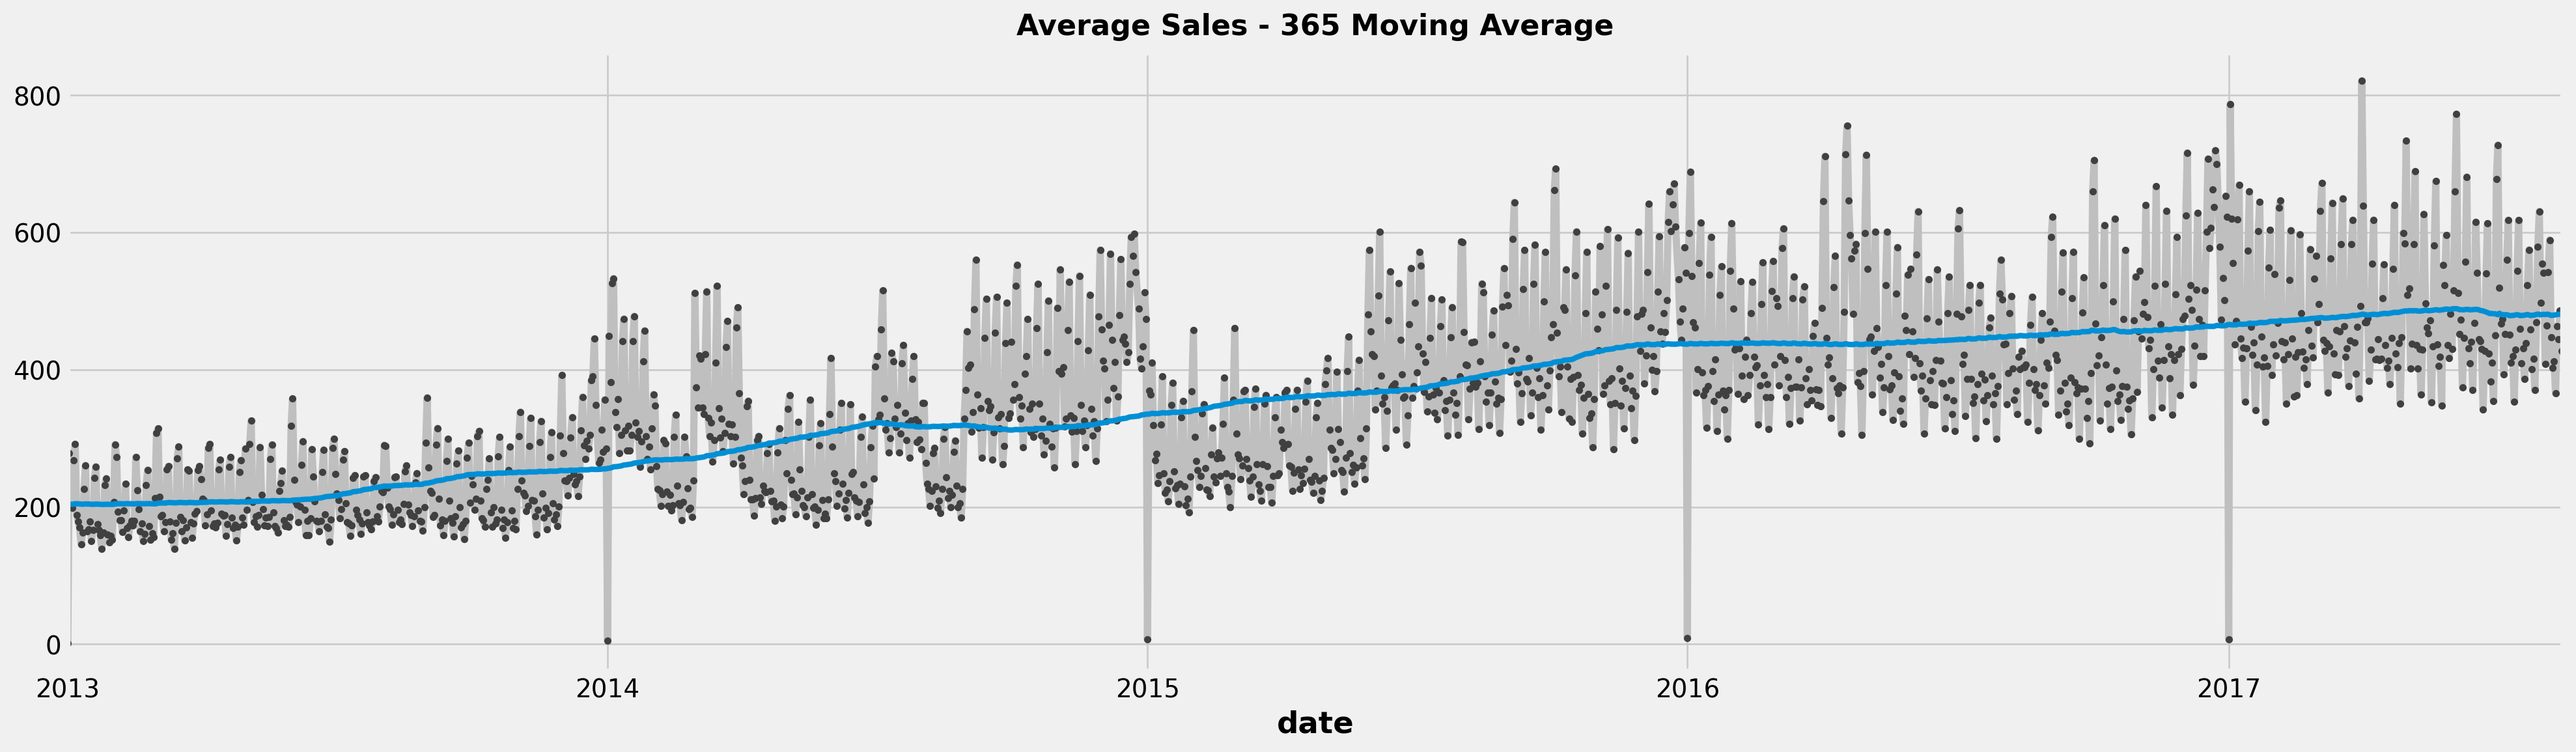

In [331]:
## estimate trend using moving average plot

trend = average_sales.rolling(
    window=365,    # smooth out short-term fluctuations within the year 
    center=True,
    min_periods=183, # min non null values in window to compute average. using half of window size
).mean()


# create MA plot
ax = average_sales.plot(**plot_params)
trend.plot(ax=ax, linewidth=3, legend=False, title="Average Sales - 365 Moving Average");

There seems to be somewhat upward linear trend in the data

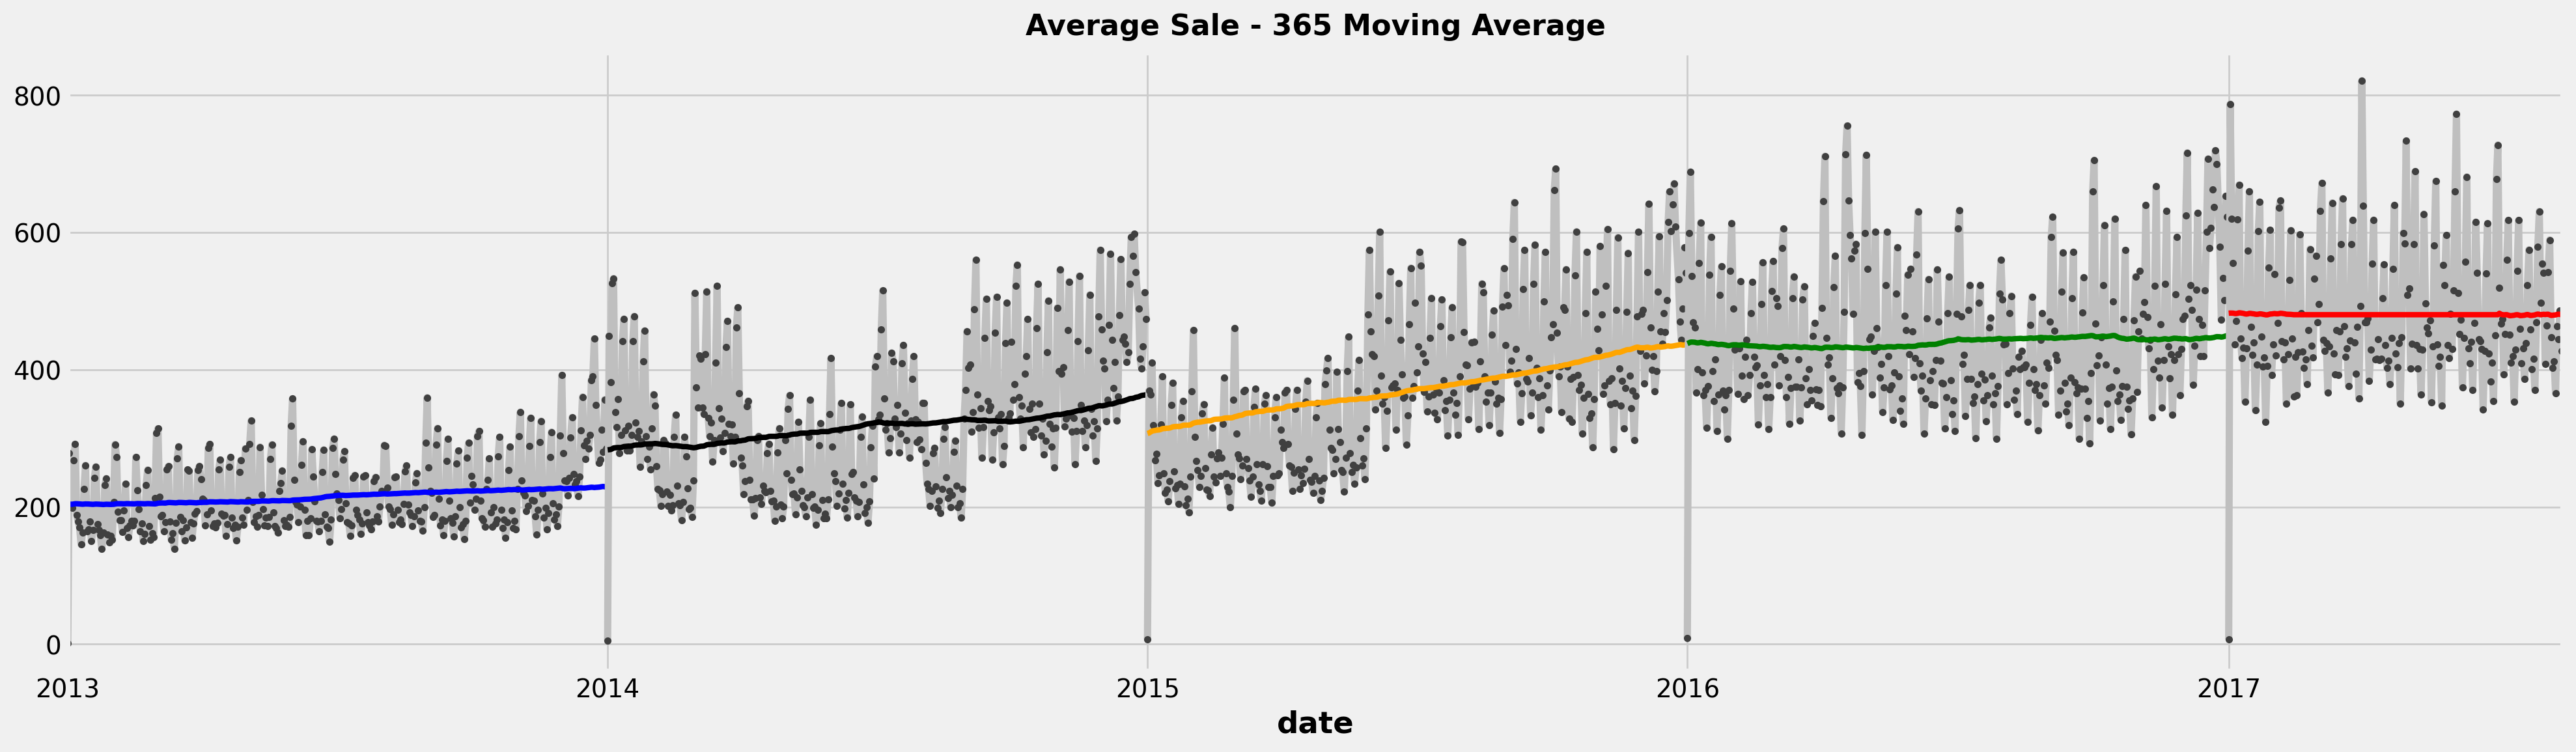

In [254]:
fig, ax = plt.subplots()
colors = ["blue", "black", "orange", "green", "red"]
color_idx = 0
for year in range(2013, 2018):
    series = average_sales.loc[str(year)]
    trend = series.rolling(
        window=365, # smooth out short-term fluctuations
        center=True,
        min_periods=15, 
    ).mean()

    # create MA plot
    ax = series.plot(**plot_params)
    trend.plot(ax=ax, linewidth=3, legend=False, title=f"Average Sale - 365 Moving Average", color = colors[color_idx]);
    color_idx += 1

- Here, we see difference in trend for each year. 
- Particularly for 2017, we notice the trend line is horizontal

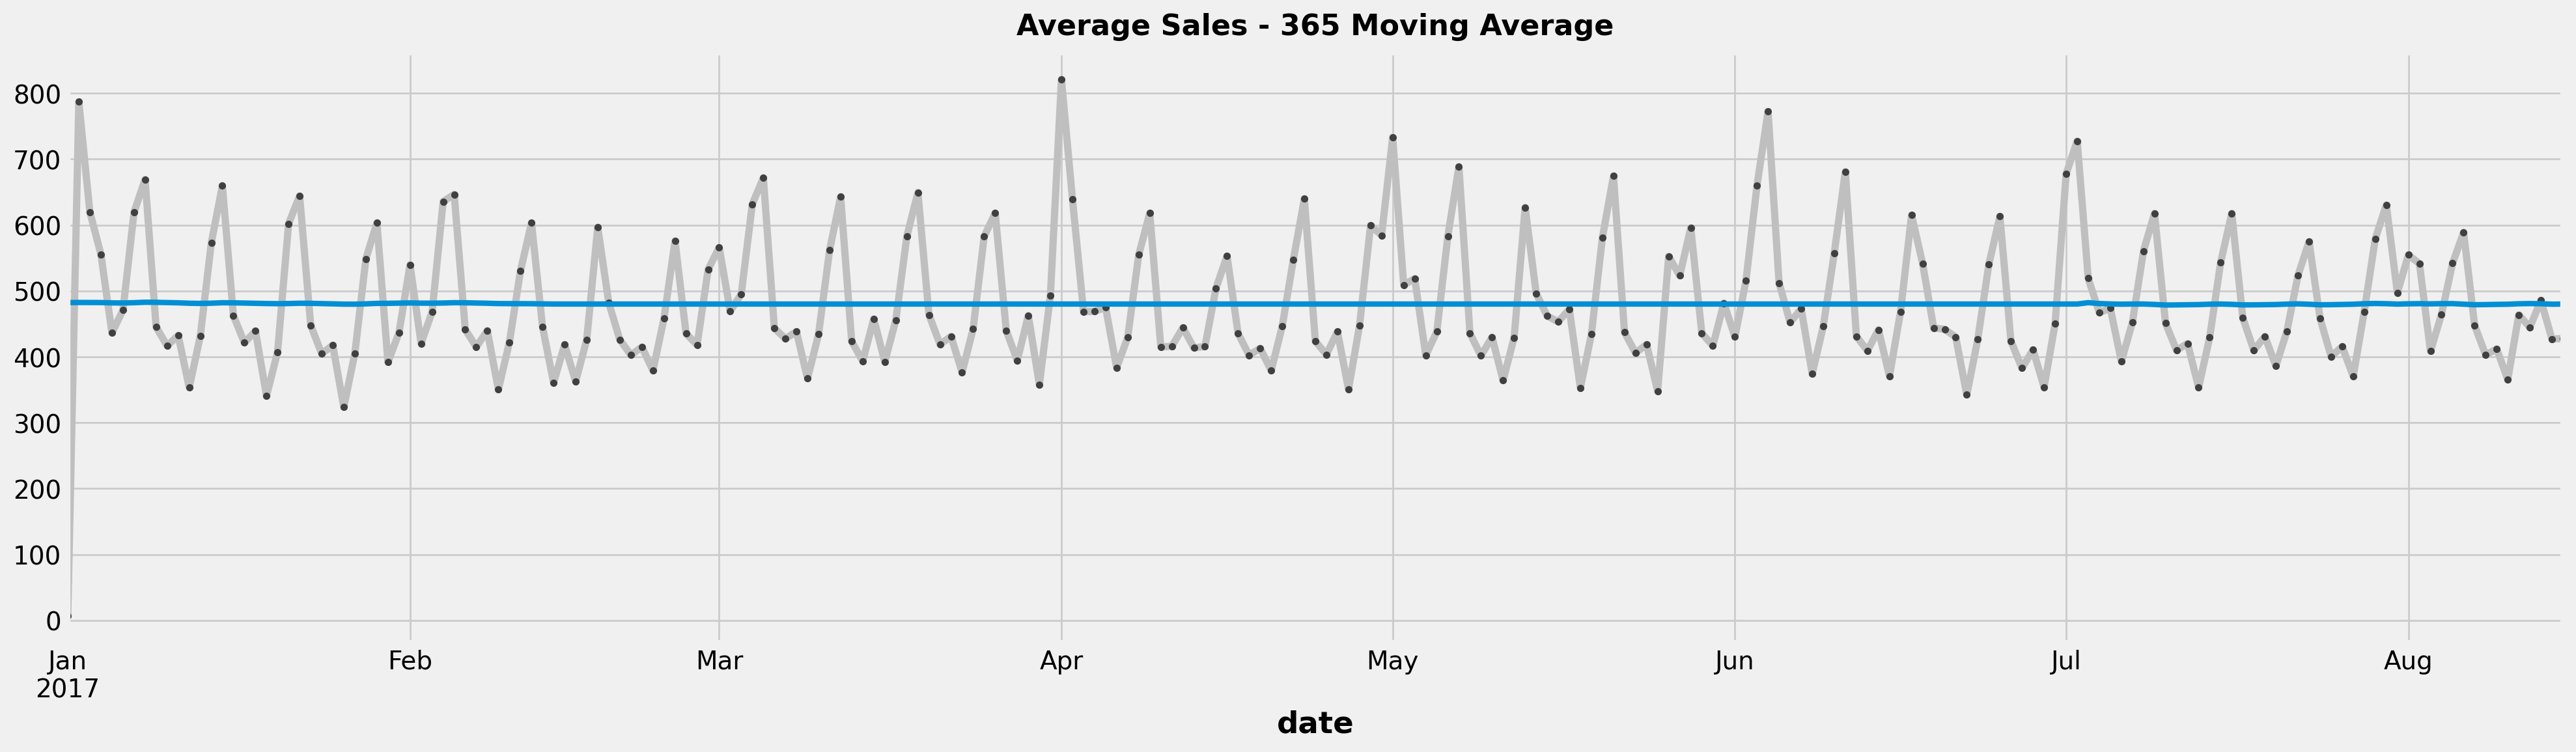

In [332]:
average_sales_2017 = average_sales.loc["2017"]

trend = average_sales_2017.rolling(
    window=365,    # smooth out short-term fluctuations within the year 
    center=True,
    min_periods=183, # min non null values in window to compute average. using half of window size
).mean()


# create MA plot
ax = average_sales_2017.plot(**plot_params)
trend.plot(ax=ax, linewidth=3, legend=False, title="Average Sales - 365 Moving Average");

- Using all available data can provide a comprehensive understanding of the underlying patterns and trends in the time series
-  it is important to keep the goal of our analysis in mind: we're interested in capturing the most current bahaviour and making short-term predictions i.e. forecasting 15 days into the future.
- since the trend in 2017 is significantly different from the preceeding years  
- focusing on the most recent data -- say 2017 data -- may be more relevant since 
- Downside: smaller data which may significantly impact our training and validation set in terms of being large enough to capture the variability and trends of the time series and potentially lead to overfitting


- We proceed to use the most recent data -- 2017. We'll investigate if it's a better approach or to use the entire dataset
- The trend line is horizontal, which indicates that there is no significant upward or downward movement in the data over time. 
- Data points fluctuates around a constant mean value, suggesting a stable behaviour
- Since there is no discernible trend over time, we can focuse on investigating the structure of the seasonality in the data

## Engineering Seasonality 

- use seasonal plots and periodograms to investigate structure of seasonality 
- engineer features to capture seasonality based on insights


### Identify Seasonality

- Just as MA plot can be used to identify trend, seasonal plot, periodograms, or correlograms like acf or pacf can also be used to identify seasonality 
- seasonal plots shows segments of series plotted against some common period, the period being the "season" you want to observe. 
- periodograms show seasonal freq components that are strong in the series. 


In [77]:
## define seasonal plot function

def seasonal_plot(X, y, period, freq, ax=None):
    """generates a seasonal plot showing segments of series plotted against some common period. 

    :param X: feature matrix
    :type X: DataFrame
    :param y: series feature (a column in X)
    :type y: Series
    :param period: season to be observed
    :type period: str (a column in X)
    :param freq: number of observation in a season
    :type freq: str (a column in X)
    :param ax: plotting axes, defaults to None
    :type ax: axes, optional
    :return: a plot
    :rtype: axes
    """
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        errorbar=('ci', False),
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax





In [ ]:
## define periodogram function

def plot_periodogram(ts, detrend='linear', ax=None):
    """_summary_

    :param ts: _description_
    :type ts: _type_
    :param detrend: _description_, defaults to 'linear'
    :type detrend: str, optional
    :param ax: _description_, defaults to None
    :type ax: _type_, optional
    :return: _description_
    :rtype: _type_
    """
    
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


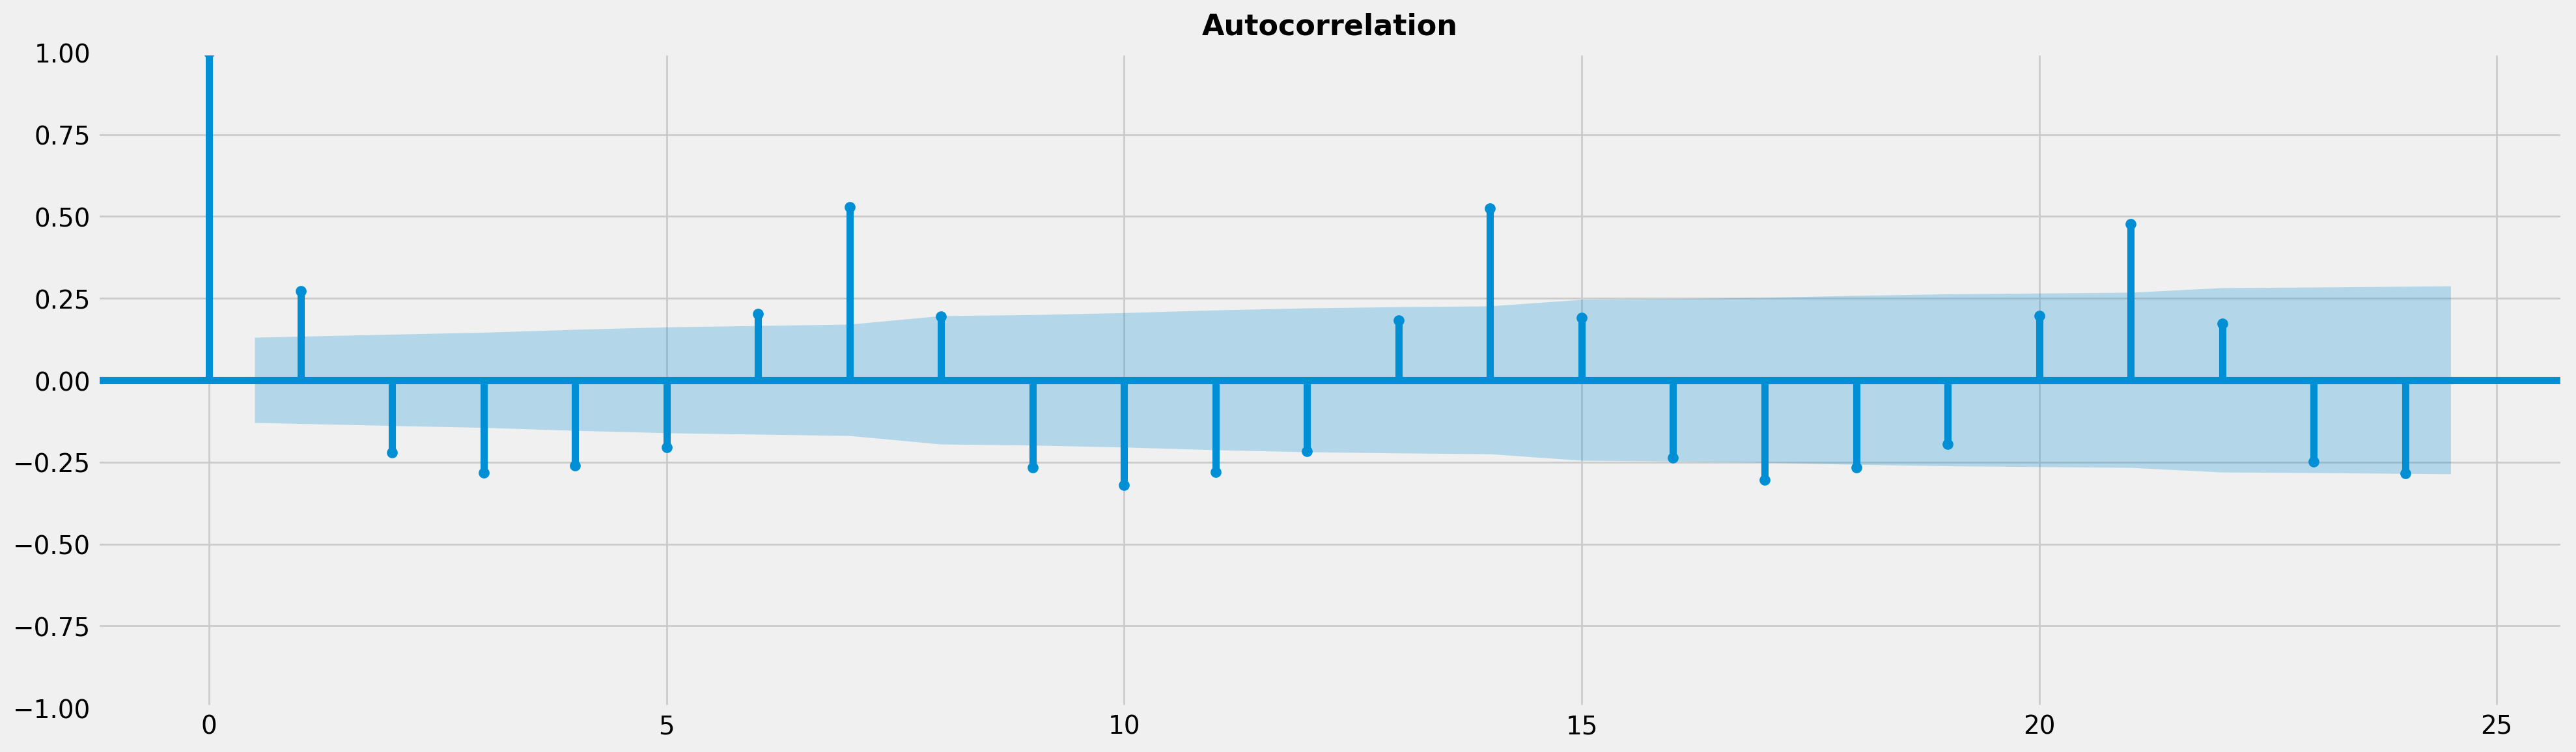

In [86]:
acf_plot = plot_acf(average_sales_2017);

aucocorrelation plot shows that strong weekly lags components: a possible indication of weekly seasonality

In [224]:
## visualize weekly season of daily observations

X = average_sales_2017.copy()
X = X.to_frame()

# days within a week
X["day"] = X.index.dayofweek
X["week"] = X.index.week 

X.head()

sales  day  week
date                             
2017-01-01    6.780304    6    52
2017-01-02  786.928379    0     1
2017-01-03  619.740224    1     1
2017-01-04  555.608004    2     1
2017-01-05  436.375395    3     1

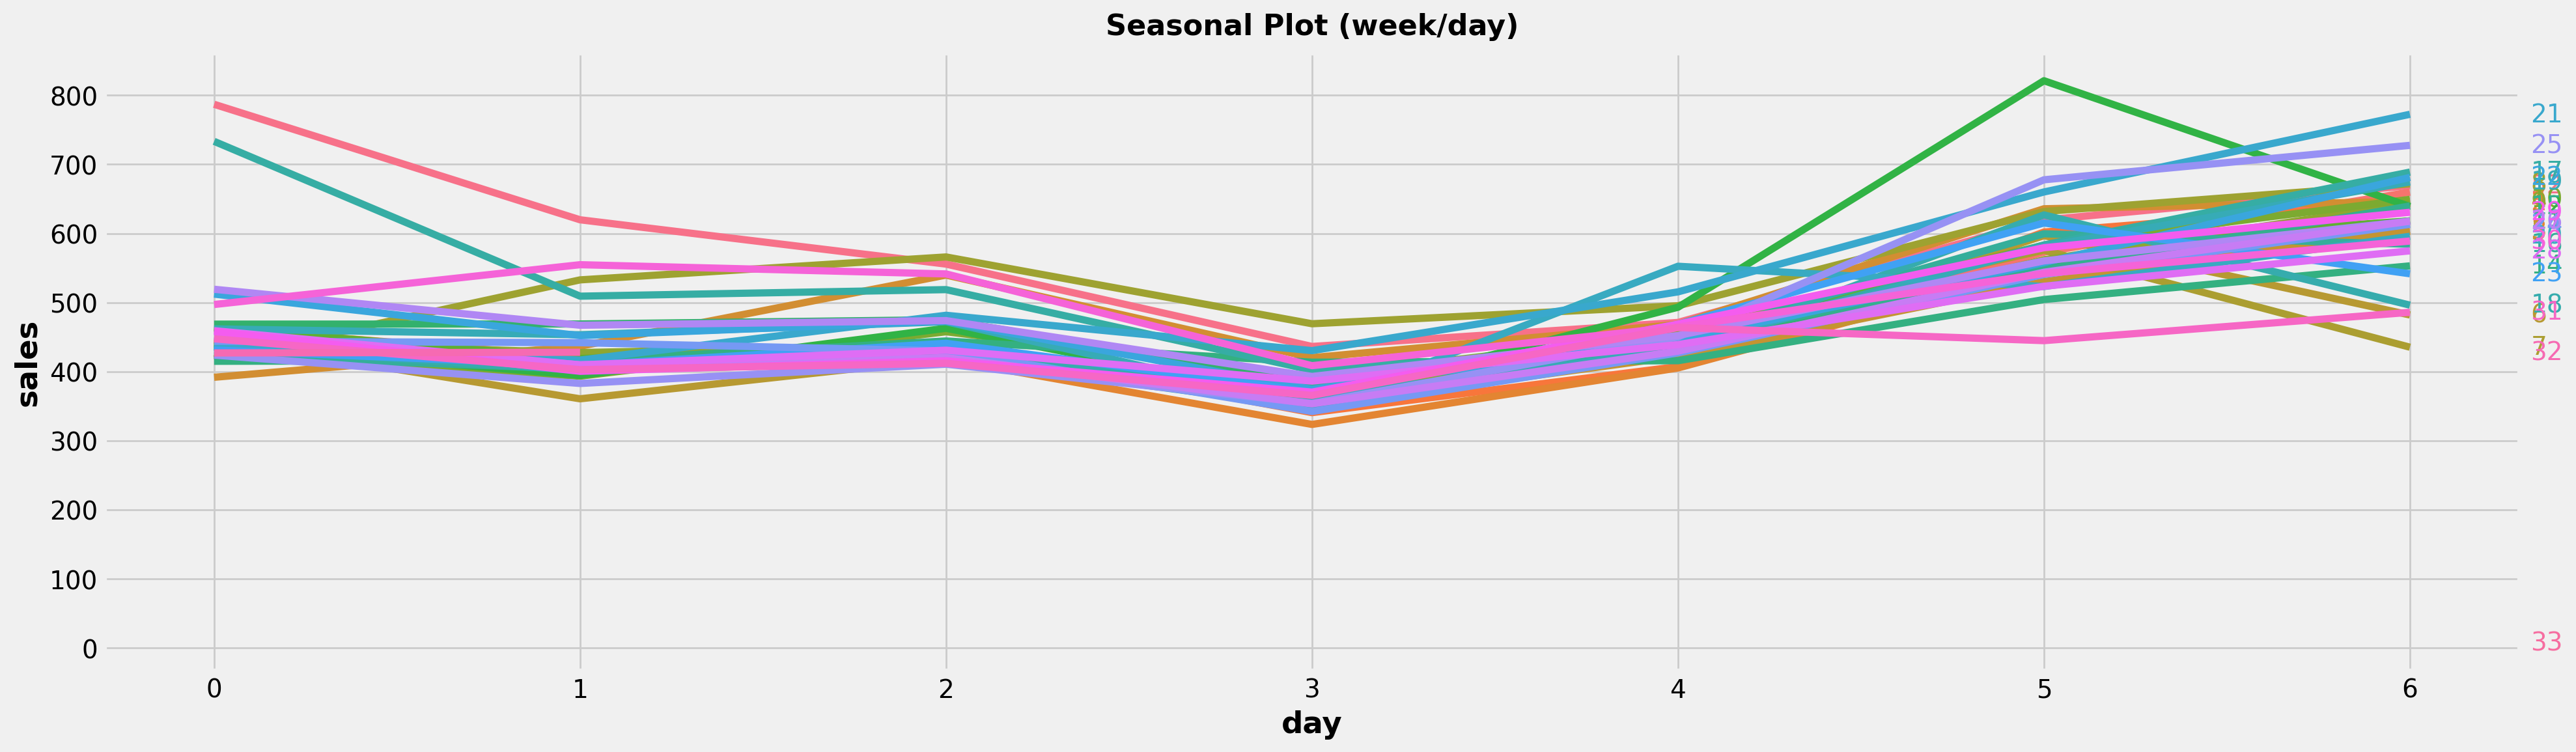

In [76]:
fig, ax = plt.subplots()

seasonal_plot(X=X, y="sales", period="week", freq="day", ax=ax);

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

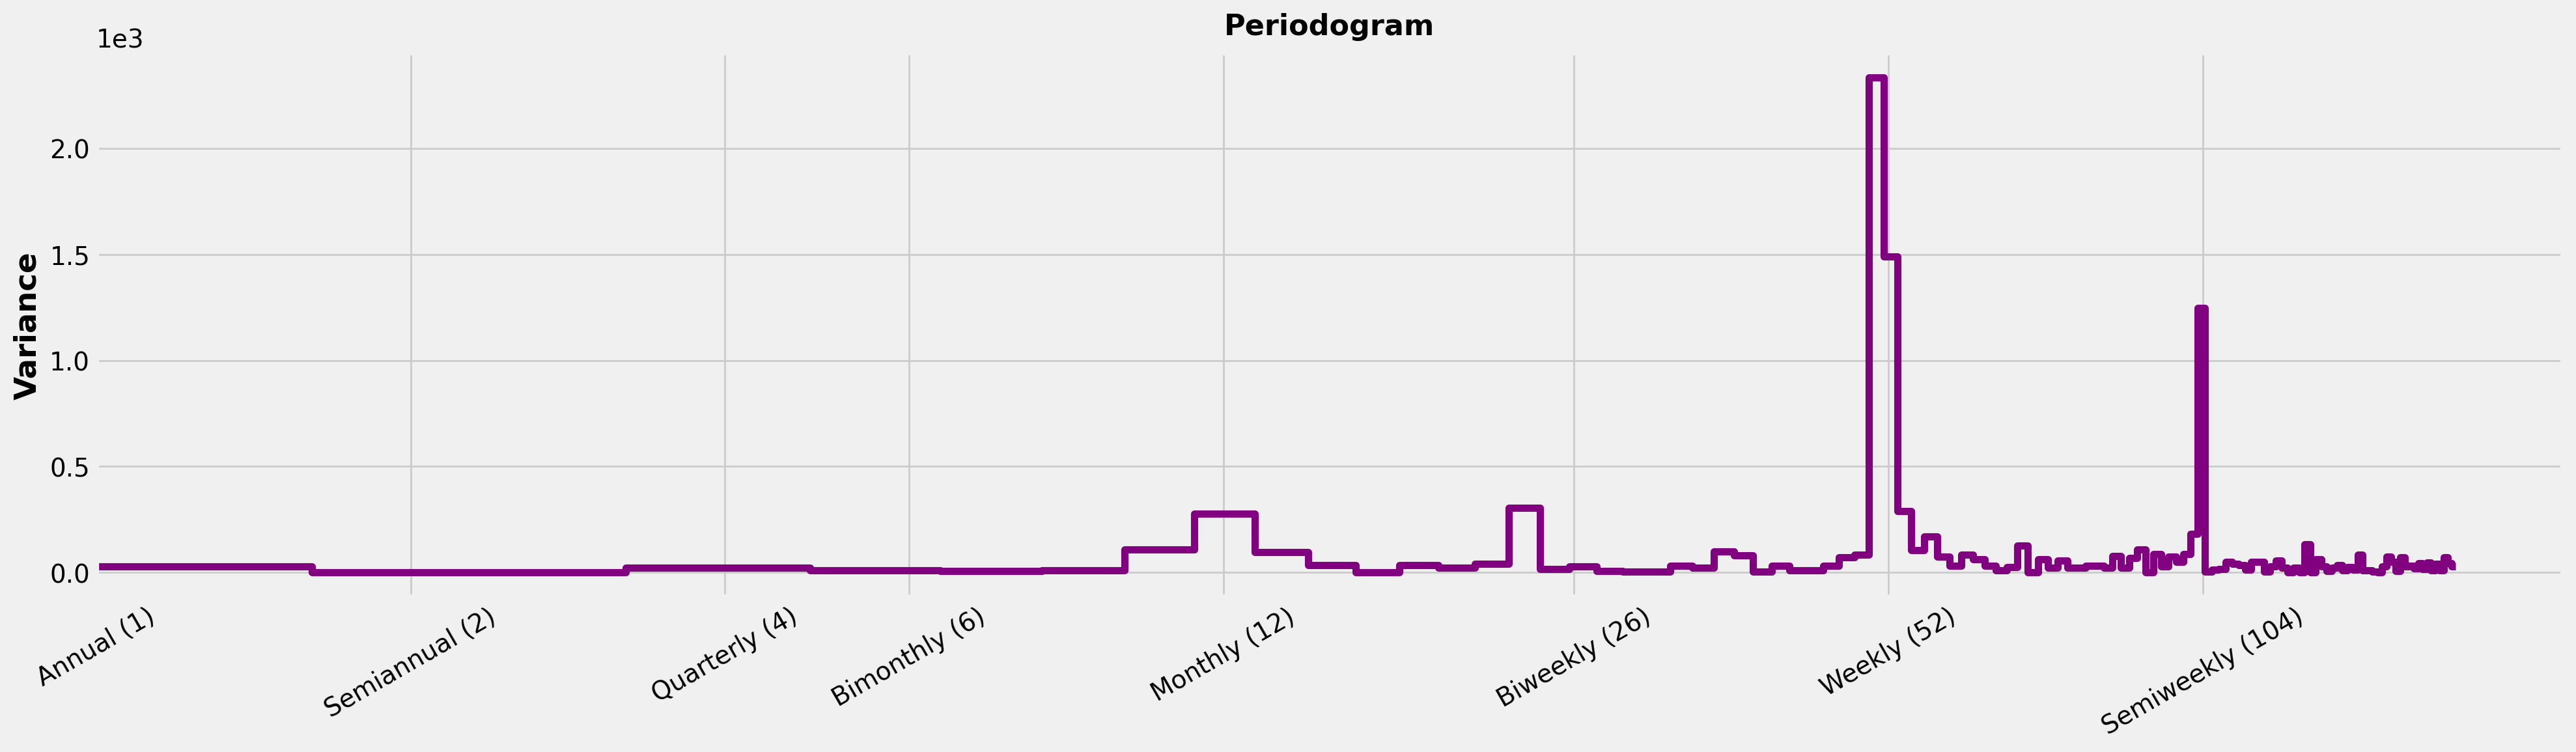

In [78]:
plot_periodogram(X.sales);

- Both seasonal plot and periodogram suggest a strong weekly seasonality. 
- From the periodogram, it appears there may be some monthly and biweekly components as well. 
- In fact, the notes to the Store Sales dataset say wages in the public sector are paid out biweekly, on the 15th and last day of the month -- a possible origin for these seasons.


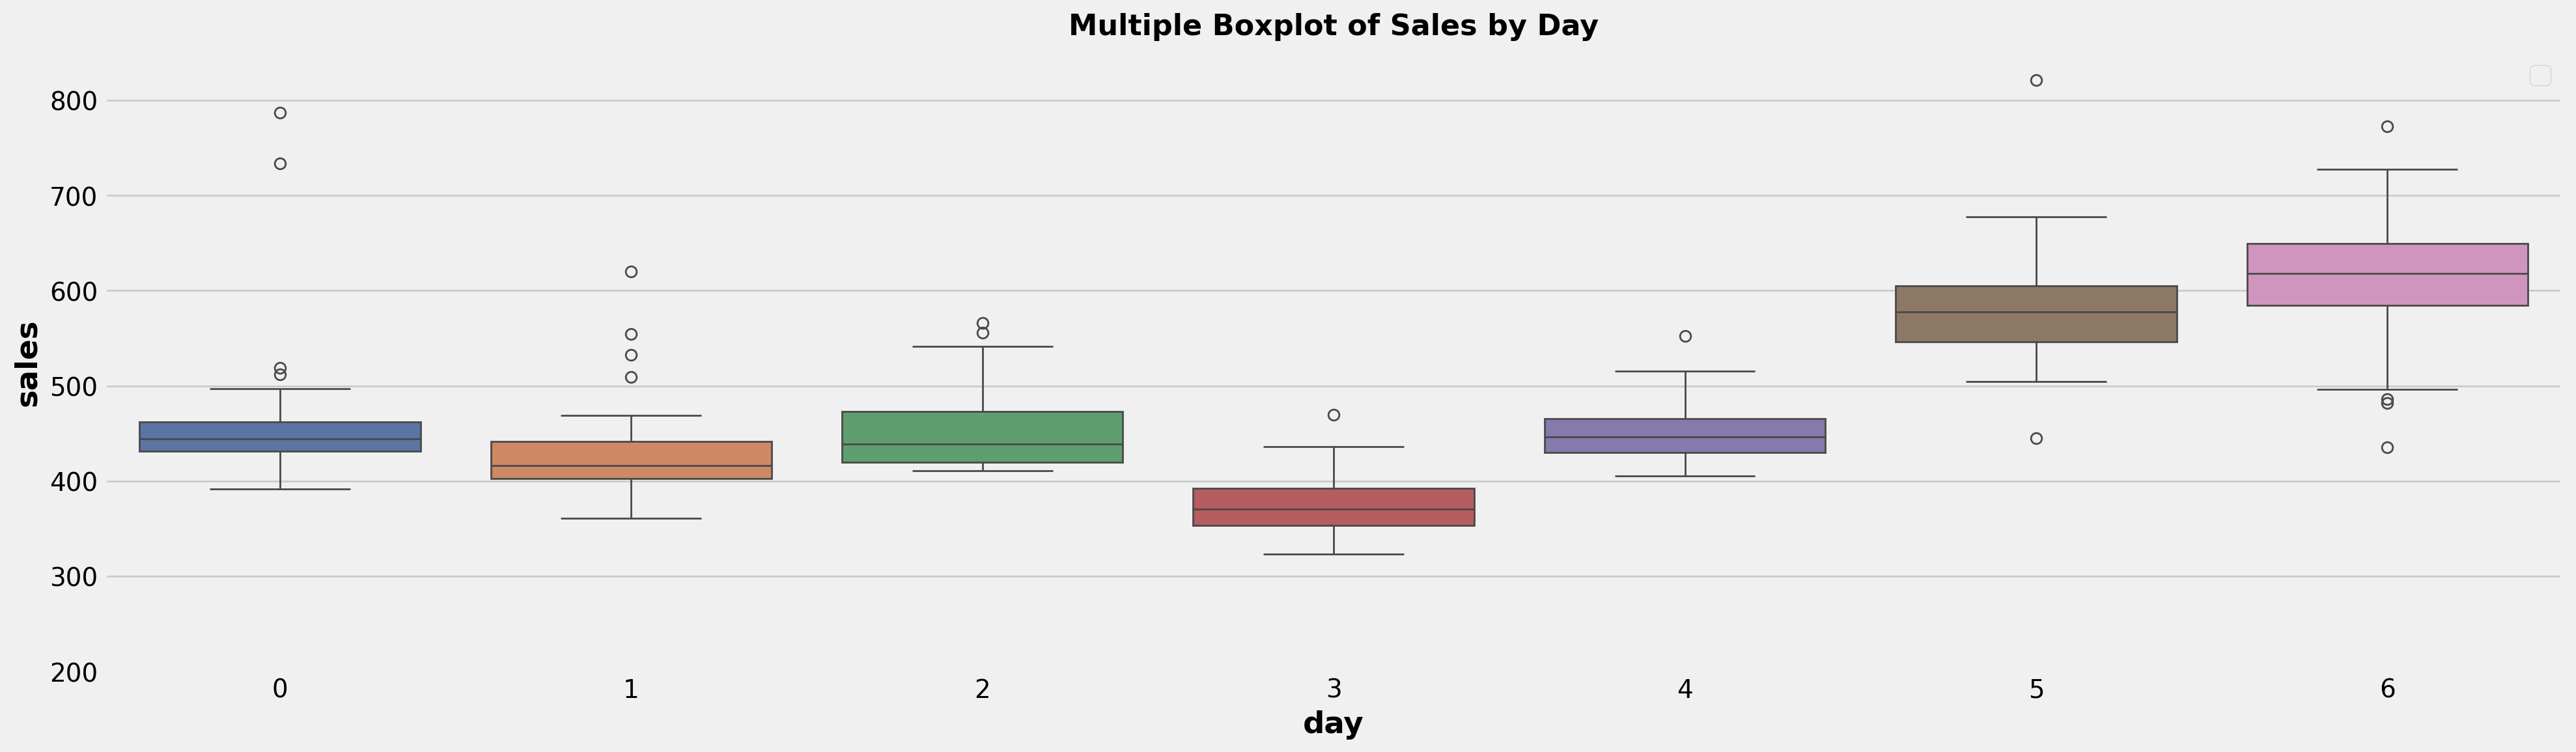

In [231]:
ax = sns.boxplot(data=X, x="day", y="sales", hue="day", palette="deep")
ax.set_ylim(bottom=200, top=850)
ax.set_title("Multiple Boxplot of Sales by Day")
ax.legend([]);

- outliers may be legitimate values explainable by factors such as holidays or oil prices
- based on insights we may delete them or engineer features, such as holiday features to explain these outliers to our model 
- There's a significant difference between the means of sales for each day. 
- Including weekly seasonal features could our model 

### Create Seasonal Features

- we explore different ways of creating seasonal features


### Train/Test split
- The split should preserve the temporal order and structure of the data
- 

In [282]:
train_end_date = datetime(2017, 8, 5)

train_df = average_sales_2017.loc[:train_end_date]
eval_df = average_sales_2017.loc[train_end_date + timedelta(days=1):]

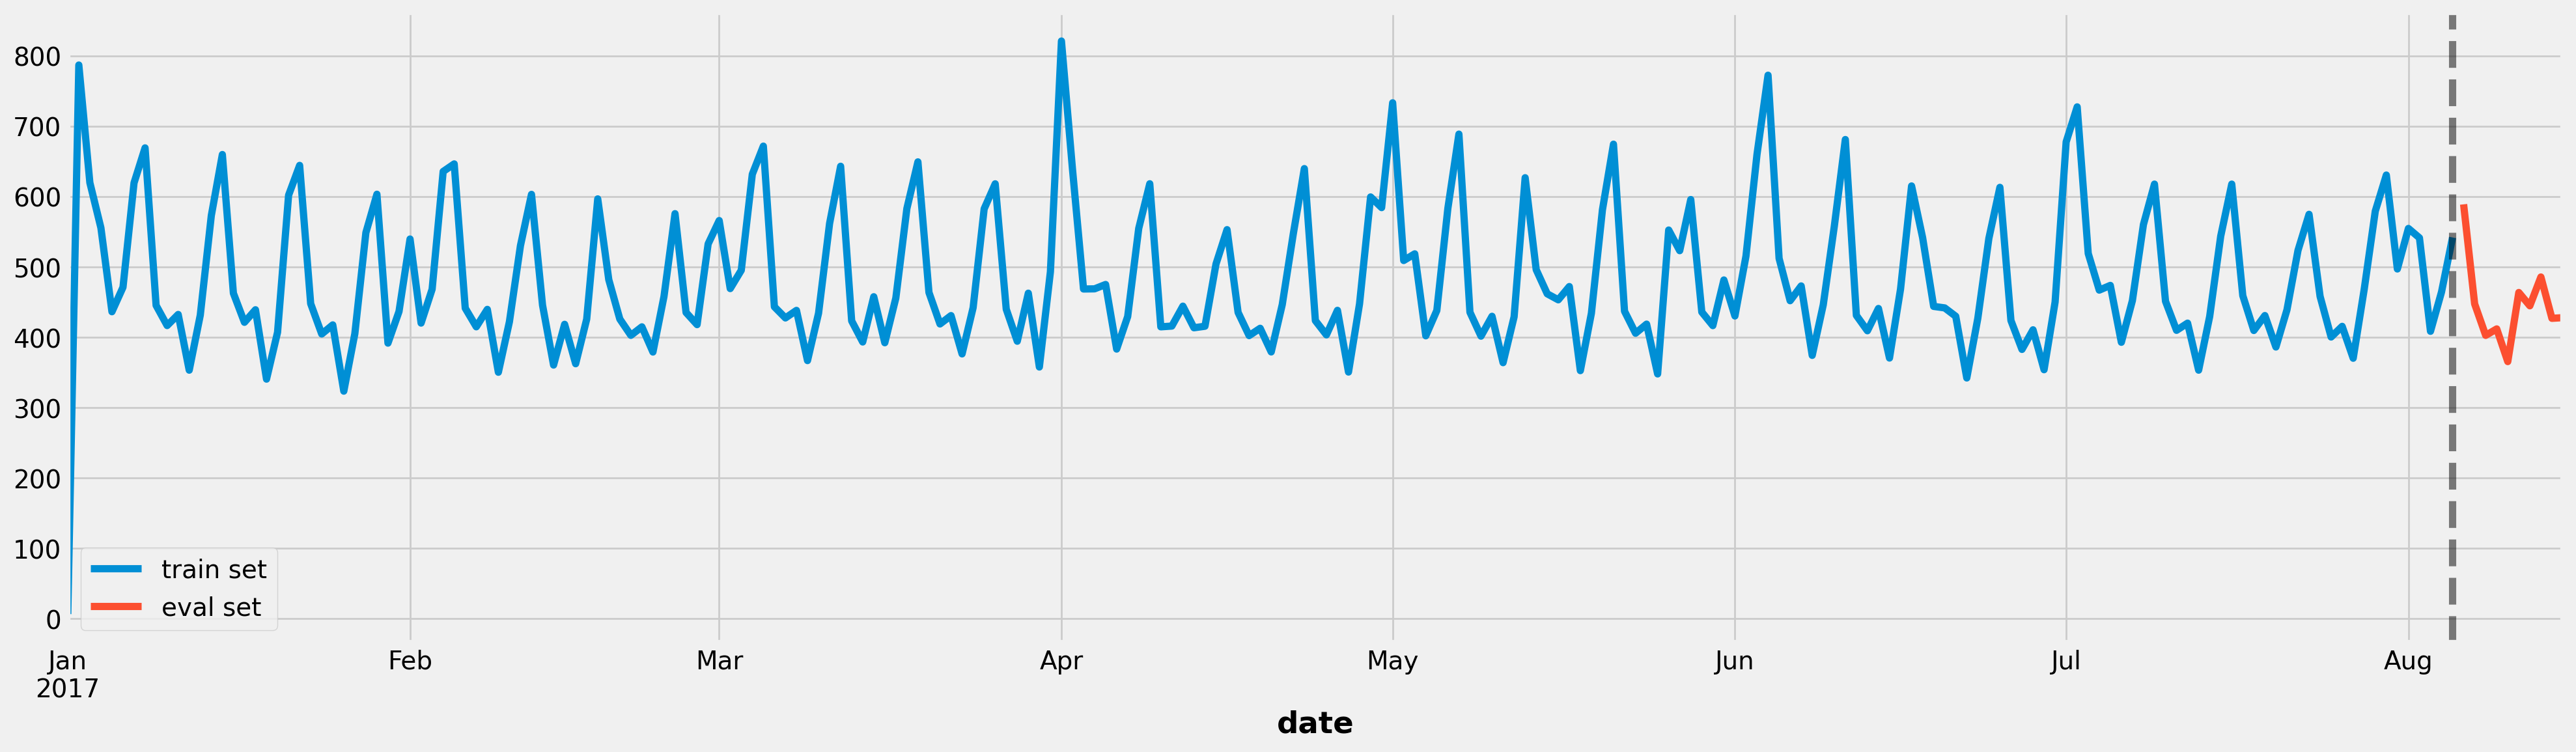

In [283]:
ax = train_df.plot(label="train set")
eval_df.plot(ax=ax, label="eval set")
plt.axvline(x=train_end_date, color="k", linestyle="--", alpha=0.5)
ax.legend();

- The reason why we are using a fairly small eval set is because the goal of our analysis is to make short term predictions. 
- Generally the further the test set is from the training set, the poorer the predictions of a time series model 
- since our focus is short term, any model that performs well in the short-term meets our target

- There are various ways of engineering seasonal features for a forecasting task. 
- Let's begin with the simplest seasonal features and model 

### First set of features: X_1

In [284]:
## create weekly and daily seasonal features
y_train = train_df.copy()
y_eval = eval_df.copy()

def create_features(series):
    
    X = pd.DataFrame()

    X["day"] =  series.index.day_of_week
    X["week"] = series.index.week
    X.index = series.index
    
    return X 

X_1 = create_features(y_train)
X_1

day  week
date                 
2017-01-01    6    52
2017-01-02    0     1
2017-01-03    1     1
2017-01-04    2     1
2017-01-05    3     1
...         ...   ...
2017-08-01    1    31
2017-08-02    2    31
2017-08-03    3    31
2017-08-04    4    31
2017-08-05    5    31

[217 rows x 2 columns]

In [285]:
## create features for evaluation set

X_1_eval = create_features(y_eval)
X_1_eval

day  week
date                 
2017-08-06    6    31
2017-08-07    0    32
2017-08-08    1    32
2017-08-09    2    32
2017-08-10    3    32
2017-08-11    4    32
2017-08-12    5    32
2017-08-13    6    32
2017-08-14    0    33
2017-08-15    1    33

### Train model and make predictions

In [286]:
## define function to train model 

def fit_predict(X_train, y_train, model, X_eval=None):
    
    """function to train and predict in and out of sample

    :return: in and out sample predictions
    :rtype: pandas series
    """

    if X_eval is None:
        
        fitted_model = model.fit(X_train, y_train)

        y_preds = pd.Series(
            fitted_model.predict(X_train),
            index=X_train.index,
            name="In sample"
        )
        
        return y_preds
    else:
    
        fitted_model = model.fit(X_train, y_train)

        y_preds = pd.Series(
            fitted_model.predict(X_train),
            index=X_train.index,
            name="In sample"
        )
        
        y_fore = pd.Series(
            fitted_model.predict(X_eval),
            index=X_eval.index,
            name="Out of sample"
            
        )
    
        return y_preds, y_fore



In [287]:
## make predictions using a linear regression model 

y_preds, y_fore = fit_predict(X_train=X_1, y_train=y_train,
                              model=LinearRegression(), X_eval=X_1_eval)



### Visualize predictions

In [288]:
## define funciton to plot predictions

def plot_predictions(series, y_preds, y_fore):
    
    ax = series.plot(**plot_params, alpha=0.7, 
                                title="2017 Average sales", 
                                ylabel="items sold")
    y_preds.plot(ax=ax, label="In sample predicitons")
    y_fore.plot(ax=ax, label="Out of sample predictions")
    ax.legend();

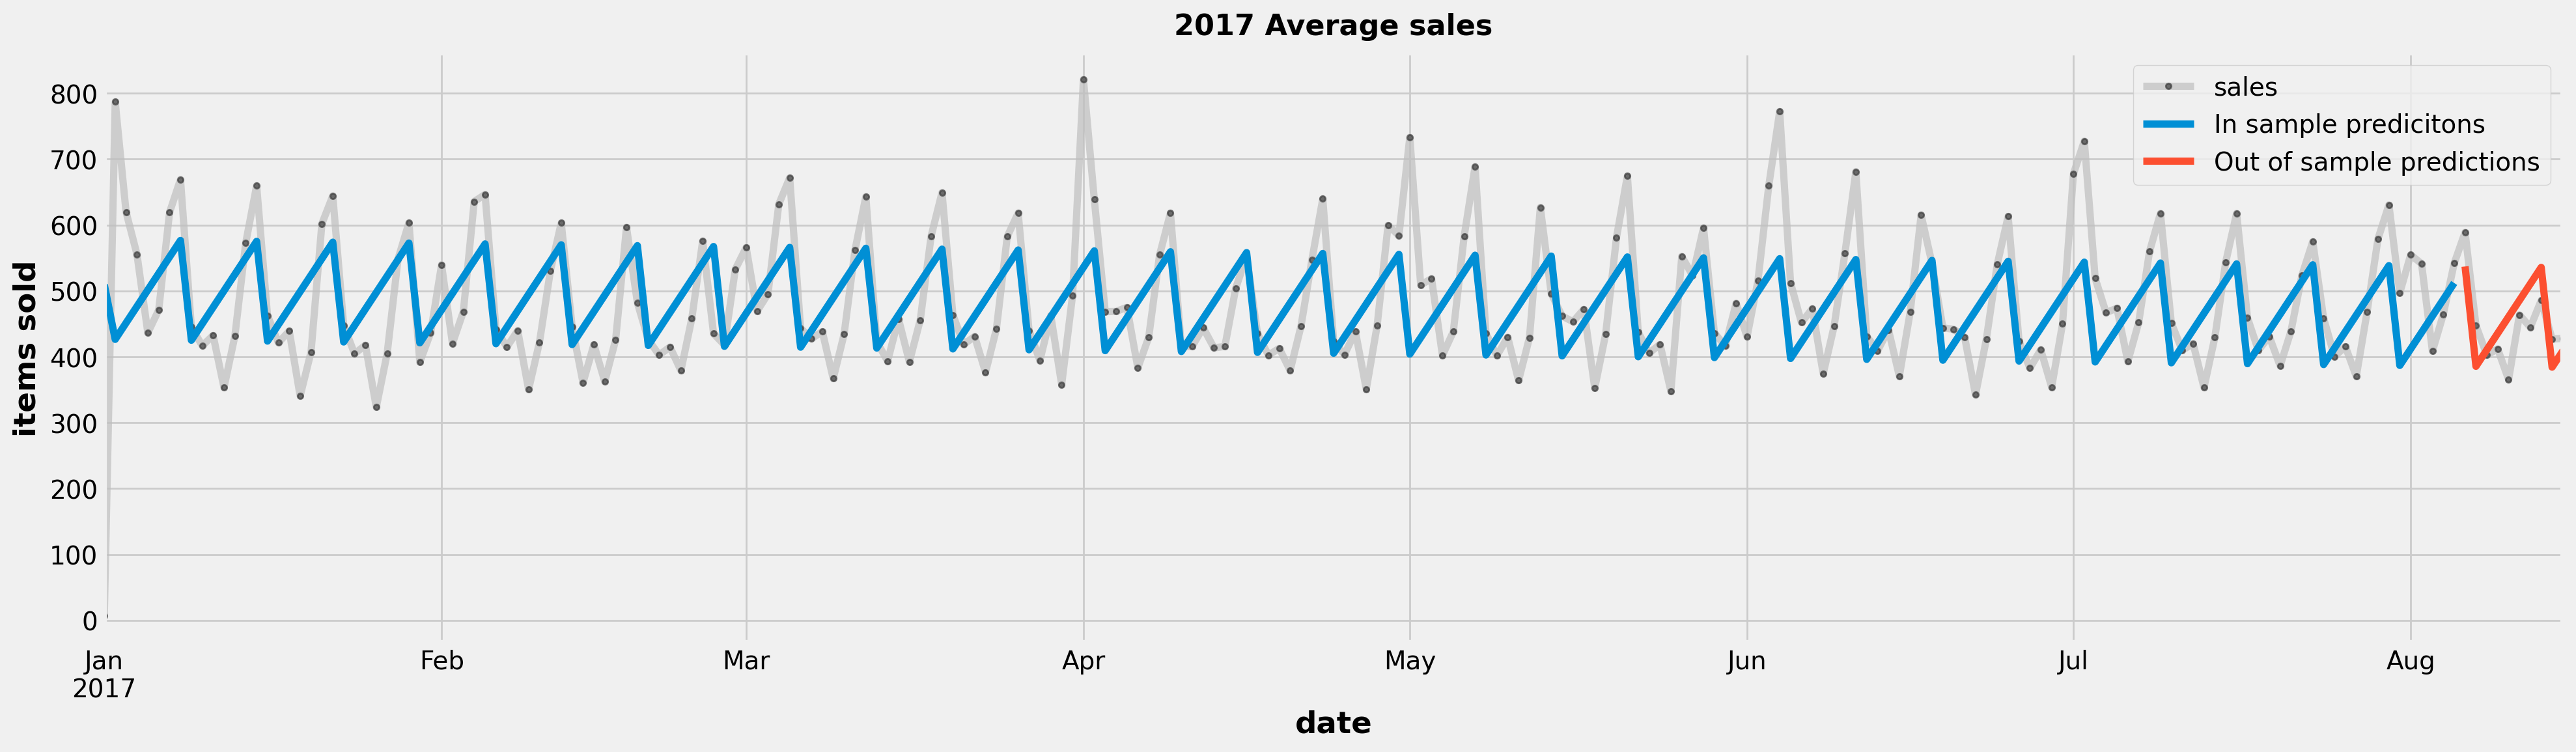

In [289]:
y = average_sales_2017.copy()

plot_predictions(series=y, y_preds=y_preds, y_fore=y_fore)

- Our predictions seem to follow the pattern in the series. 
- However, there seem to be more to learn.
- But, how can we tell if our model has sufficiently learned the components of the series and there's no more improvements that can be made?
- we use the concept of white noise








### White Noise
A time series is said to be white noise if: 

1. mean is zero
2. std is constant over time
3. corr between lags is 0 (no autocorrelation)

<img src="../ts-pp-gwn.jpg">


- white noise is not predictable. 
- time series models are generally represented as: $y_t = signal + noise$
- if we can show that the residuals of our model is white noise, then we can conclude that we have sufficiently learned from the time series 
- we may test if the residuals are white noise using: 
1. visual inspections
2. check ACF. correlogram should show that lags are not sifnificant or near insignificance 



### Evaluate model performance and plot residuals

- With a small sample size, the model's performance on the evaluation set might not be a reliable indicator of its true generalization performance.
- time series cross validation may be used. 
- for now, we'll just evaluate using the entire dataset

In [294]:
## evaluate performance

def score_dataset(series, y_preds, y_fore):

    print( f"RMSLE: \
        {np.sqrt(mean_squared_log_error(series, pd.concat([y_preds, y_fore]))):.2f}" )
    
print("model performance with seasonal features from datetime index")
score_dataset(series=y, y_preds=y_preds, y_fore=y_fore)

model performance with seasonal features from datetime index
RMSLE:         0.32


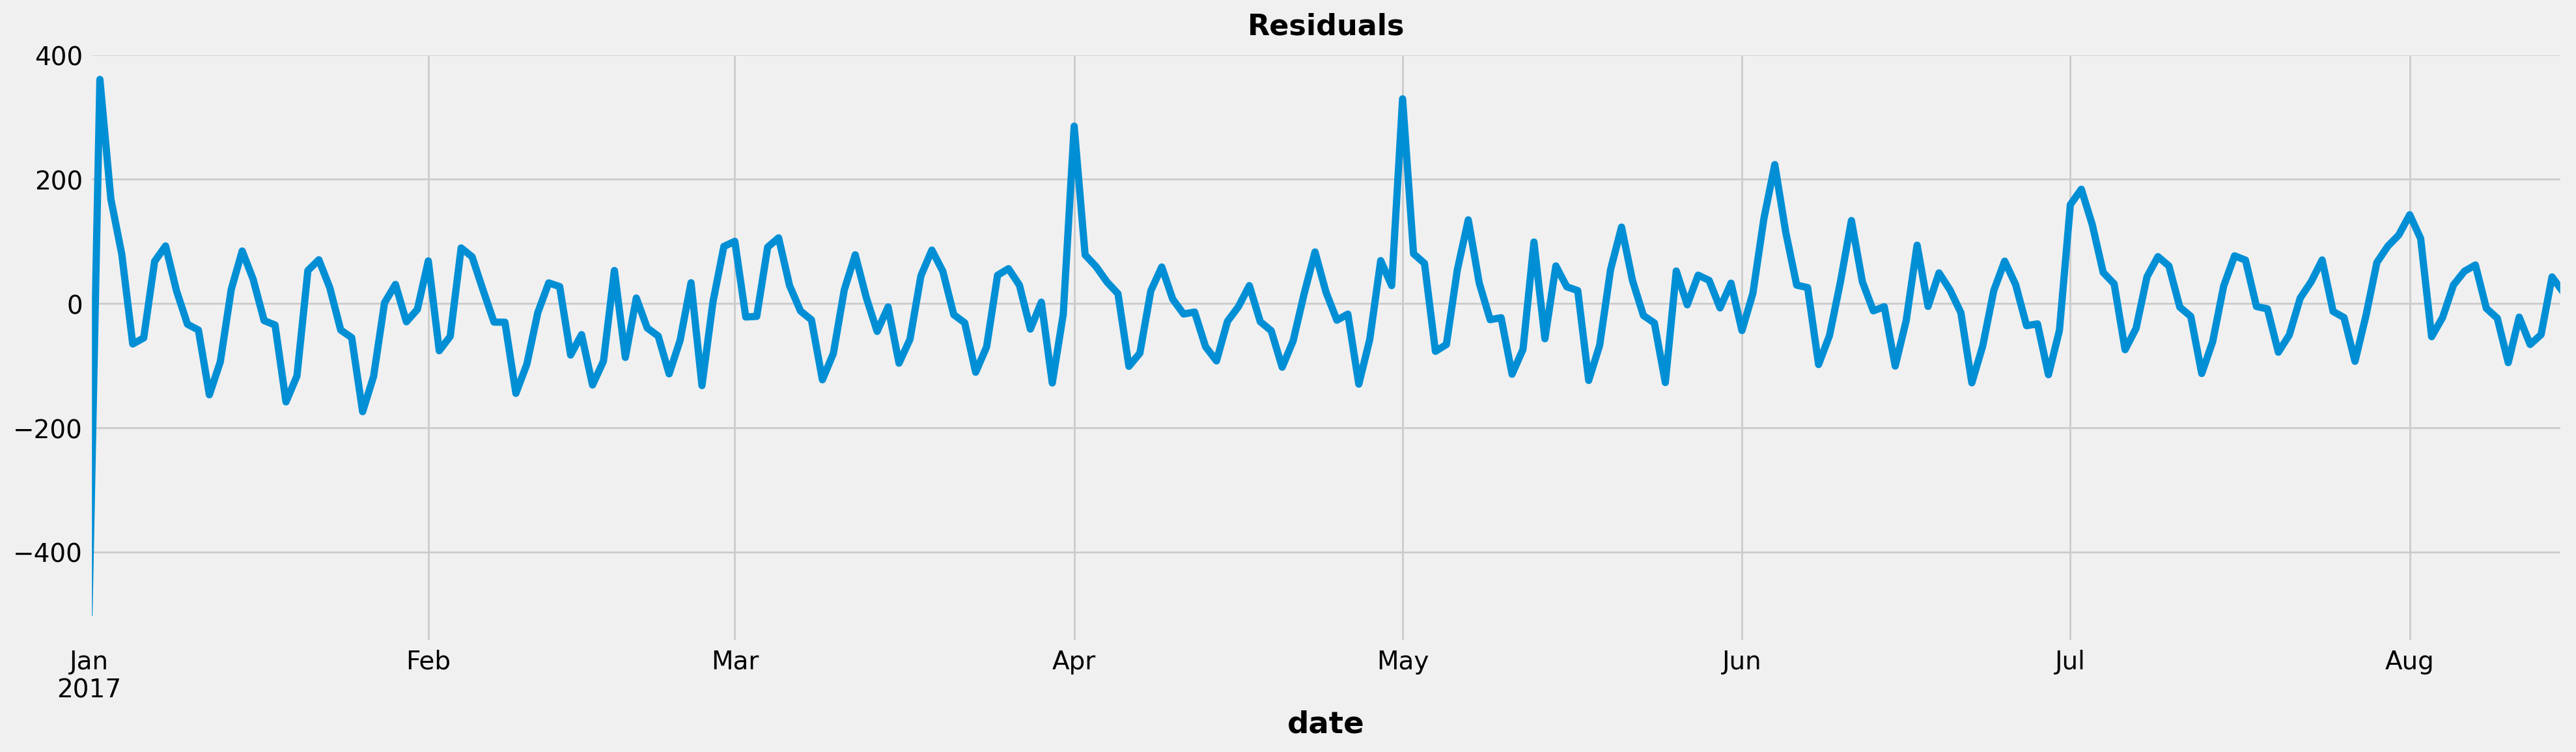

In [296]:
residuals = y - pd.concat([y_preds, y_fore])
residuals.plot(title="Residuals");

- By visual inspection, it's clear there's some seasonality still in the plot
- thus, the residuals isn't white noise
 

- This will serve as our baseline model 
- We'll build upon this to develop a more complex or hybrid models to handle the entire dataset

Second set of features: X_2 

- create seasonal indicators for weekly seasons
- create fourier features of order 4 for monthly seasons: i.e create sin/cos curve patterns that repeat 4 times or less a Month. 
- we'll create our seasonal features using DeterministicProcess. 
- We use two seasonal periods(monthly and weekly) 

In [304]:

fourier = CalendarFourier(freq="M", order=4)   # for fourier features

dp = DeterministicProcess(
    index=y_train.index,
    order=0, #  exclude trend feature
    constant=True,  # bias
    seasonal=True,  # generate seasonal indicators or dummy
    additional_terms=[fourier],
    drop=True,    
)
 
X_2 = dp.in_sample()
X_2["NewYear"] = (X_2.index.dayofyear == 1)  # take care of the dip in sales at the beginning of the year
X_2.head()

const  s(2,7)  s(3,7)  s(4,7)  s(5,7)  s(6,7)  s(7,7)  \
date                                                                
2017-01-01    1.0     0.0     0.0     0.0     0.0     0.0     0.0   
2017-01-02    1.0     1.0     0.0     0.0     0.0     0.0     0.0   
2017-01-03    1.0     0.0     1.0     0.0     0.0     0.0     0.0   
2017-01-04    1.0     0.0     0.0     1.0     0.0     0.0     0.0   
2017-01-05    1.0     0.0     0.0     0.0     1.0     0.0     0.0   

            sin(1,freq=M)  cos(1,freq=M)  sin(2,freq=M)  cos(2,freq=M)  \
date                                                                     
2017-01-01       0.000000       1.000000       0.000000       1.000000   
2017-01-02       0.201299       0.979530       0.394356       0.918958   
2017-01-03       0.394356       0.918958       0.724793       0.688967   
2017-01-04       0.571268       0.820763       0.937752       0.347305   
2017-01-05       0.724793       0.688967       0.998717      -0.050649   

            sin(3,freq=M)  cos(3,freq=M)  sin(4,freq=M)  cos(4,freq=M)  \
date                                                                     
2017-01-01       0.000000       1.000000       0.000000       1.000000   
2017-01-02       0.571268       0.820763       0.724793       0.688967   
2017-01-03       0.937752       0.347305       0.998717      -0.050649   
2017-01-04       0.968077      -0.250653       0.651372      -0.758758   
2017-01-05       0.651372      -0.758758      -0.101168      -0.994869   

            NewYear  
date                 
2017-01-01     True  
2017-01-02    False  
2017-01-03    False  
2017-01-04    False  
2017-01-05    False

In [305]:
X_2_eval = dp.out_of_sample(steps=10)
X_2_eval["NewYear"] = (X_2_eval.index.dayofyear == 1) 
X_2_eval.head()

const  s(2,7)  s(3,7)  s(4,7)  s(5,7)  s(6,7)  s(7,7)  \
2017-08-06    1.0     0.0     0.0     0.0     0.0     0.0     0.0   
2017-08-07    1.0     1.0     0.0     0.0     0.0     0.0     0.0   
2017-08-08    1.0     0.0     1.0     0.0     0.0     0.0     0.0   
2017-08-09    1.0     0.0     0.0     1.0     0.0     0.0     0.0   
2017-08-10    1.0     0.0     0.0     0.0     1.0     0.0     0.0   

            sin(1,freq=M)  cos(1,freq=M)  sin(2,freq=M)  cos(2,freq=M)  \
2017-08-06       0.848644       0.528964       0.897805      -0.440394   
2017-08-07       0.937752       0.347305       0.651372      -0.758758   
2017-08-08       0.988468       0.151428       0.299363      -0.954139   
2017-08-09       0.998717      -0.050649      -0.101168      -0.994869   
2017-08-10       0.968077      -0.250653      -0.485302      -0.874347   

            sin(3,freq=M)  cos(3,freq=M)  sin(4,freq=M)  cos(4,freq=M)  \
2017-08-06       0.101168      -0.994869      -0.790776      -0.612106   
2017-08-07      -0.485302      -0.874347      -0.988468       0.151428   
2017-08-08      -0.897805      -0.440394      -0.571268       0.820763   
2017-08-09      -0.988468       0.151428       0.201299       0.979530   
2017-08-10      -0.724793       0.688967       0.848644       0.528964   

            NewYear  
2017-08-06    False  
2017-08-07    False  
2017-08-08    False  
2017-08-09    False  
2017-08-10    False

### Train model and make predictions

In [310]:
## make predictions 

y_preds, y_fore = fit_predict(X_train=X_2, y_train=y_train,
                              model=LinearRegression(fit_intercept=False), X_eval=X_2_eval)

### visualize predicitons

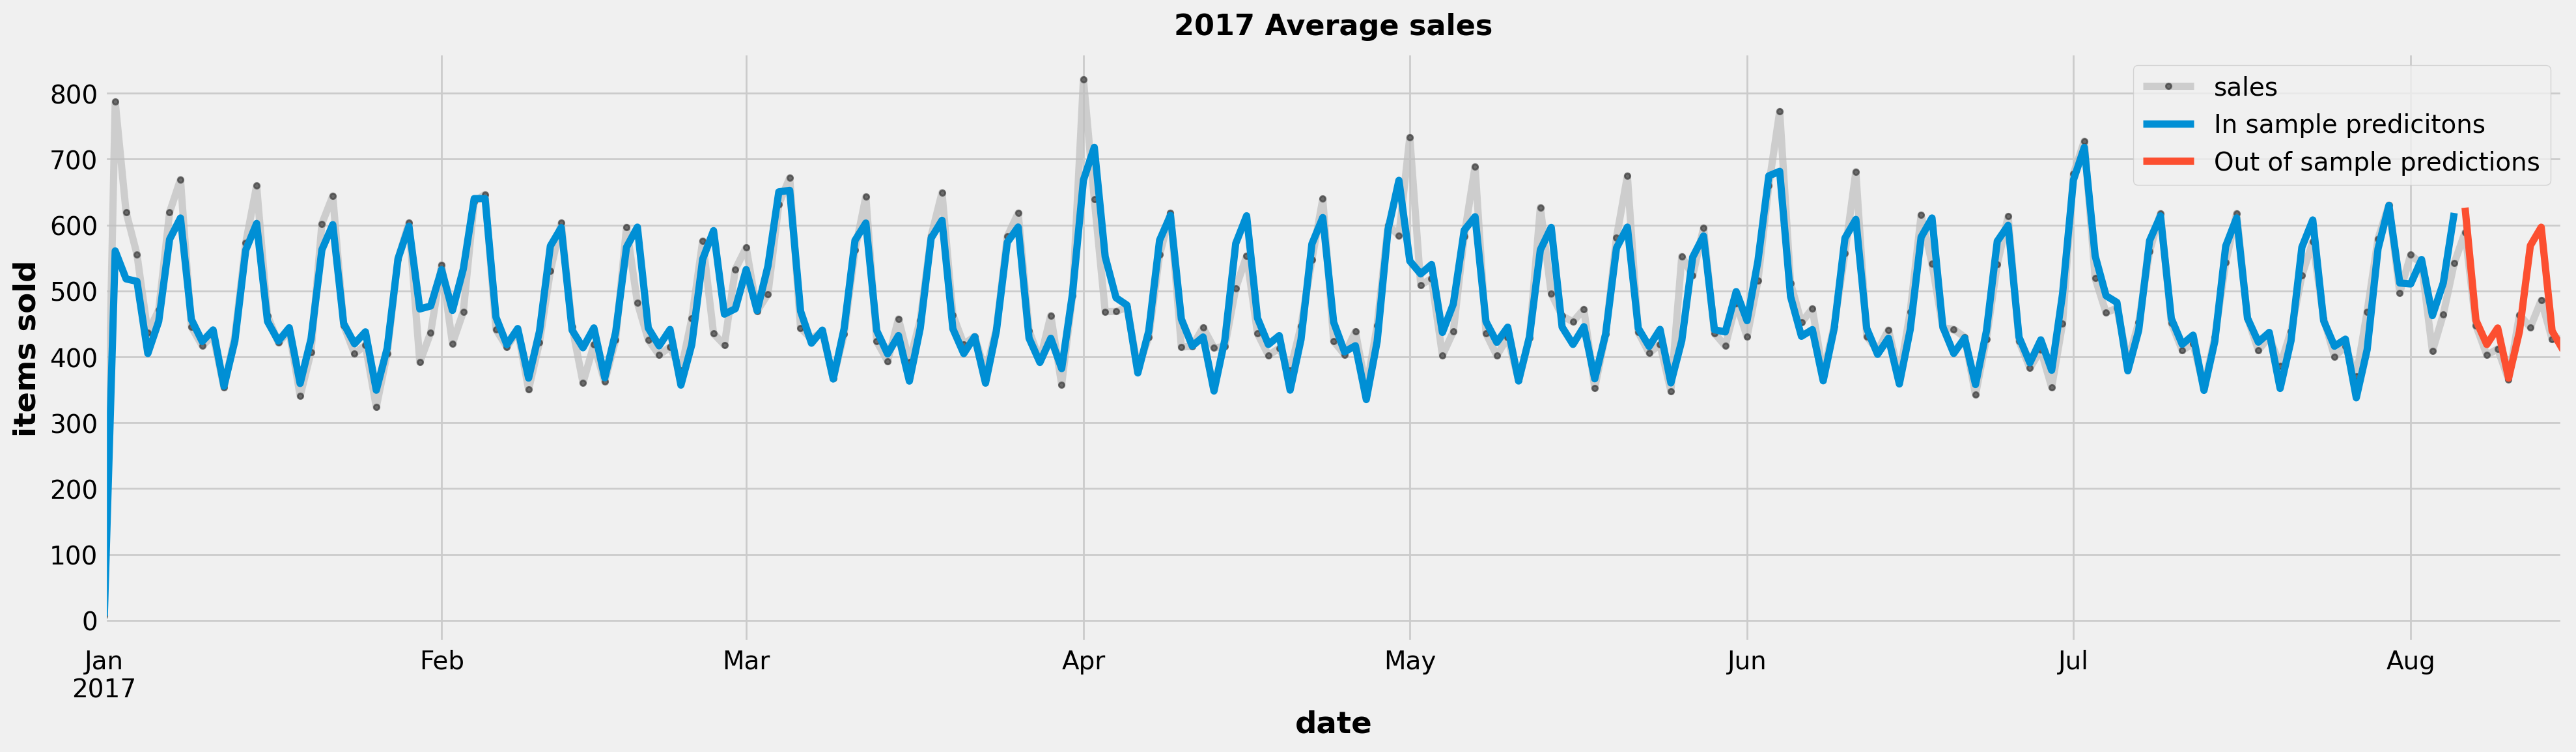

In [307]:
plot_predictions(series=y, y_preds=y_preds, y_fore=y_fore)

### Evaluate model performance and plot residuals 

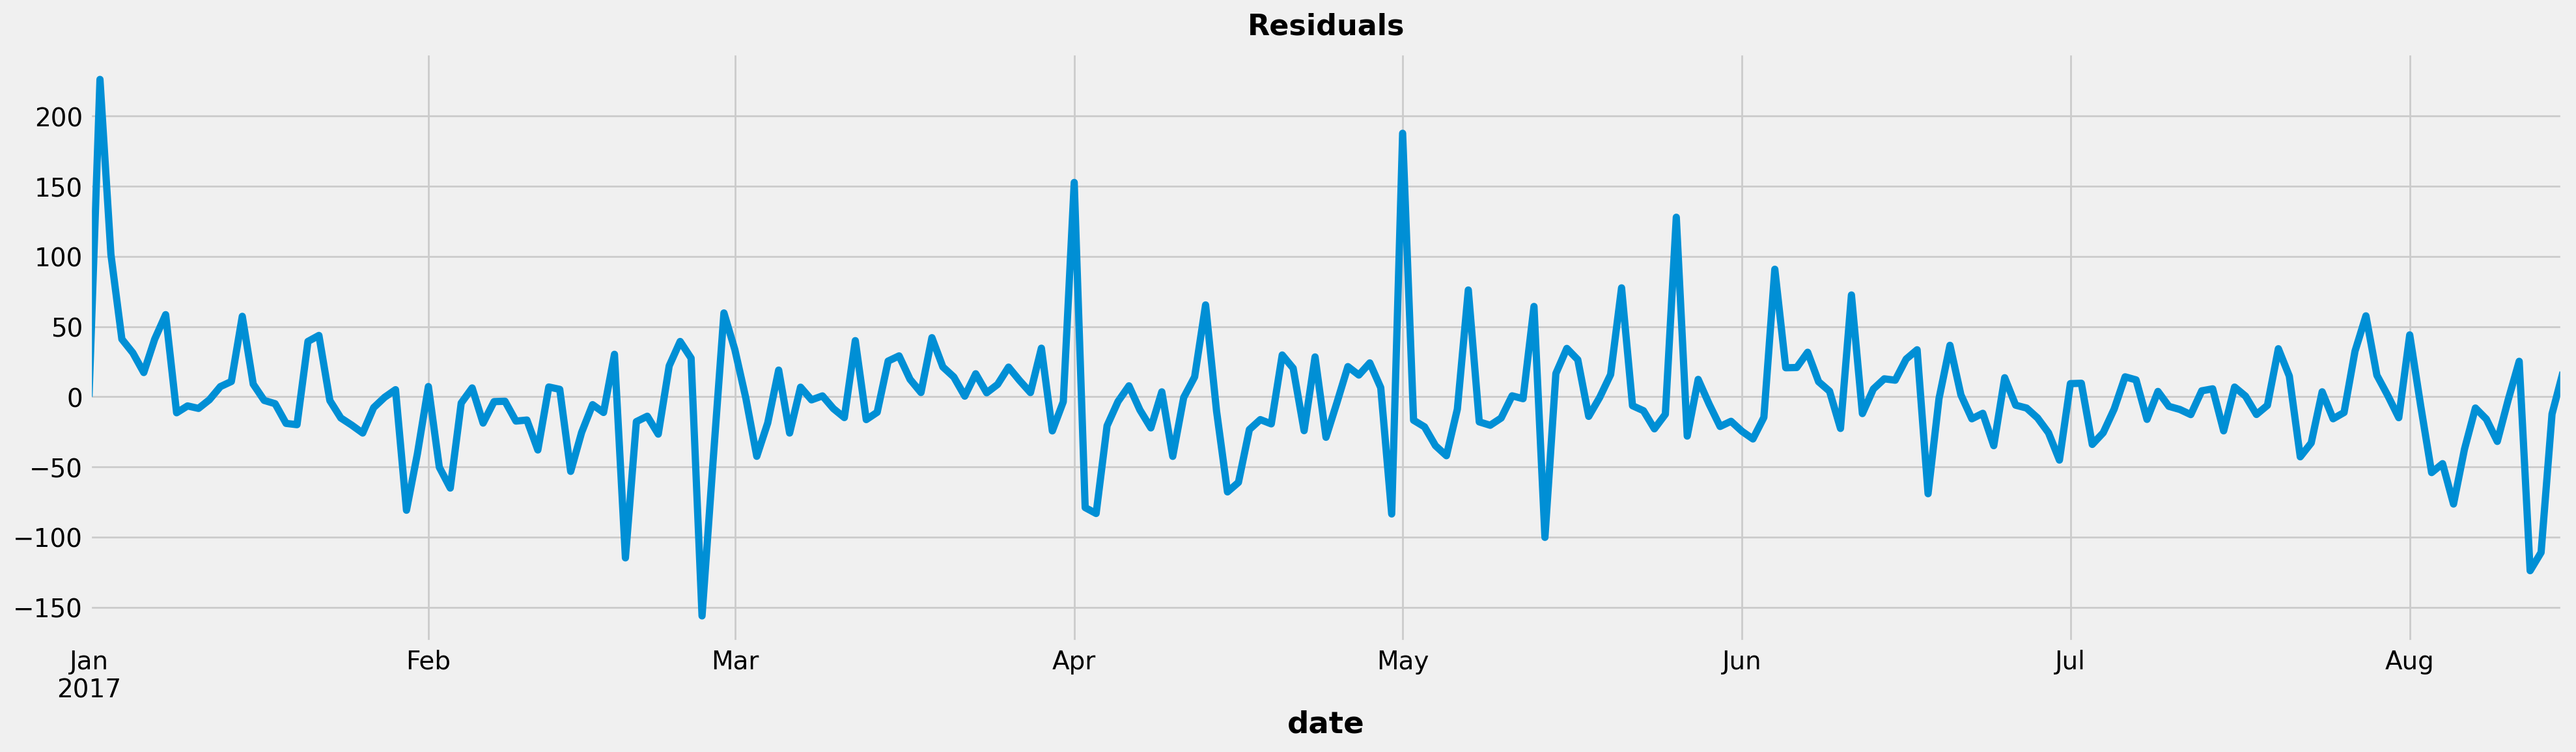

In [309]:
residuals = y - pd.concat([y_preds, y_fore])
residuals.plot(title="Residuals");

- By visual inspection, it seems our model did quite well on the training data as residuals seem to be white noise
- Let's inspect the autocorrelation plot to see if the lags are significantly correlated with series

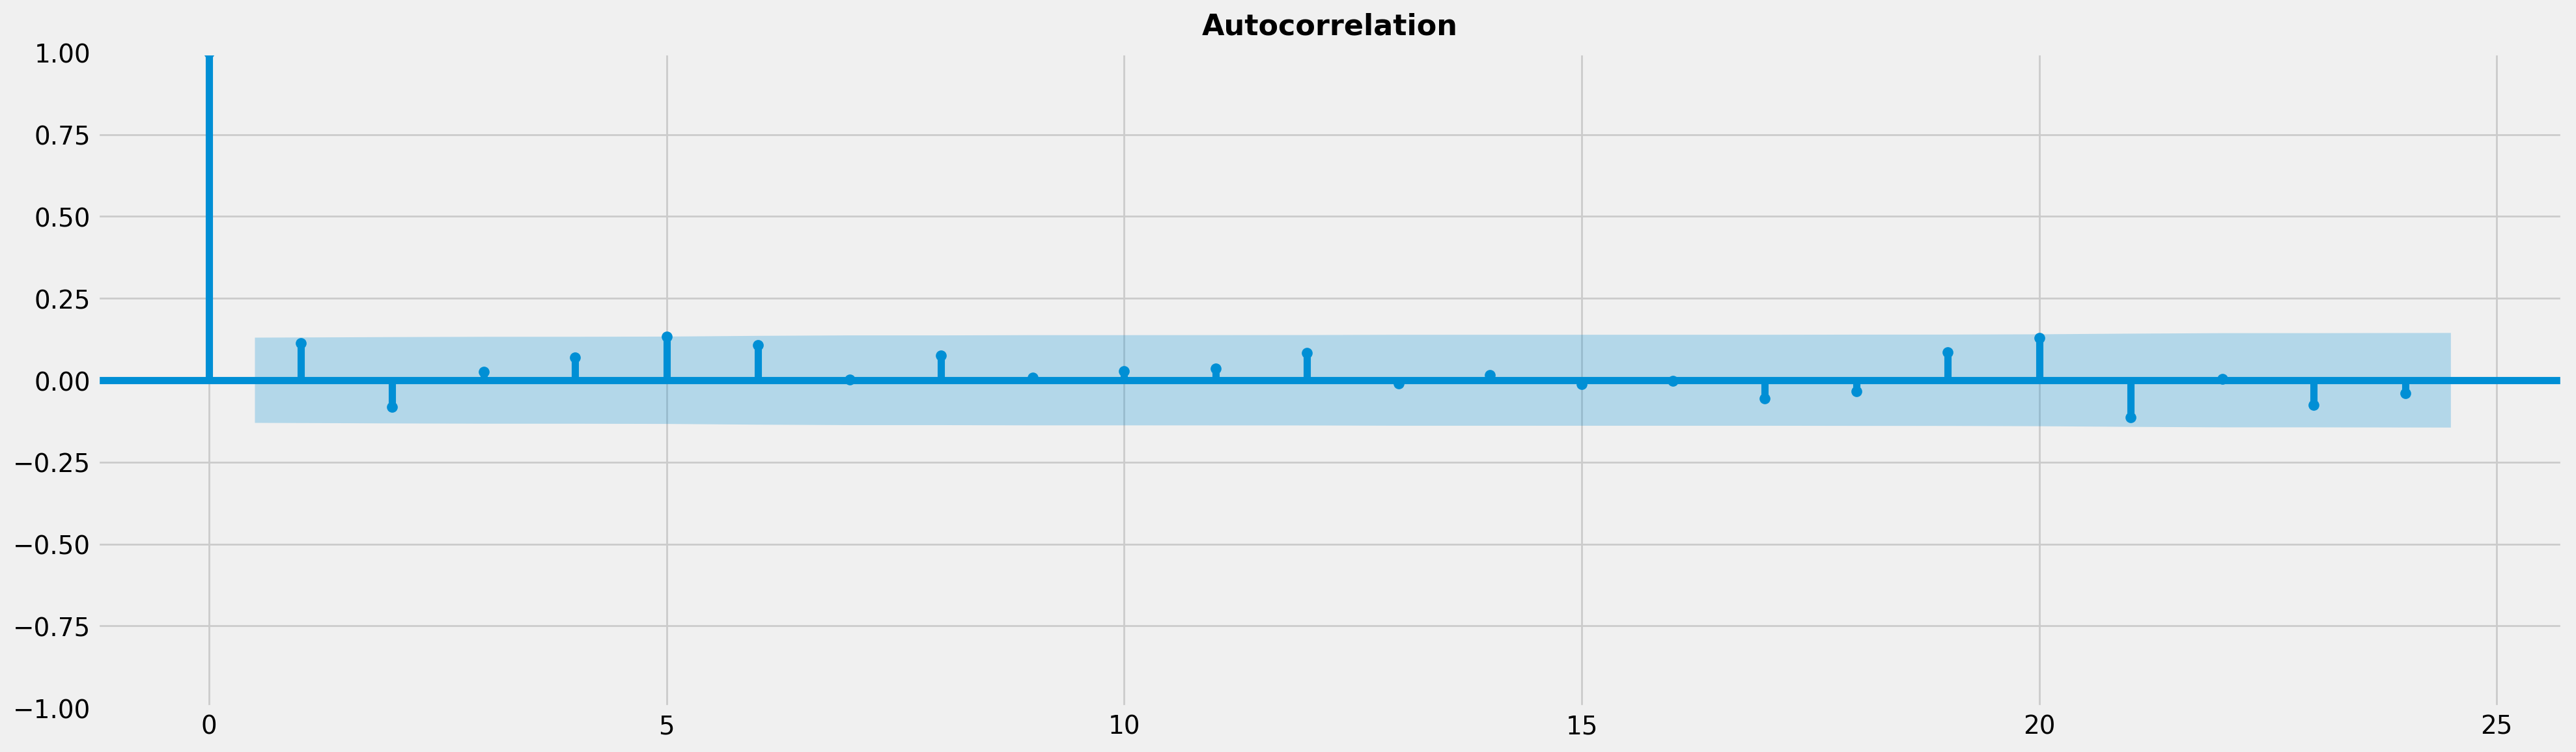

In [311]:
acf_plot = plot_acf(residuals)

- there are no significant lags indicating no autocorrelation

- When we remove the trend or seasons from a time series, it's called detrending or deseasonalizing the series respectively
- Let's look at the periodogram of the deseasonalized series. 

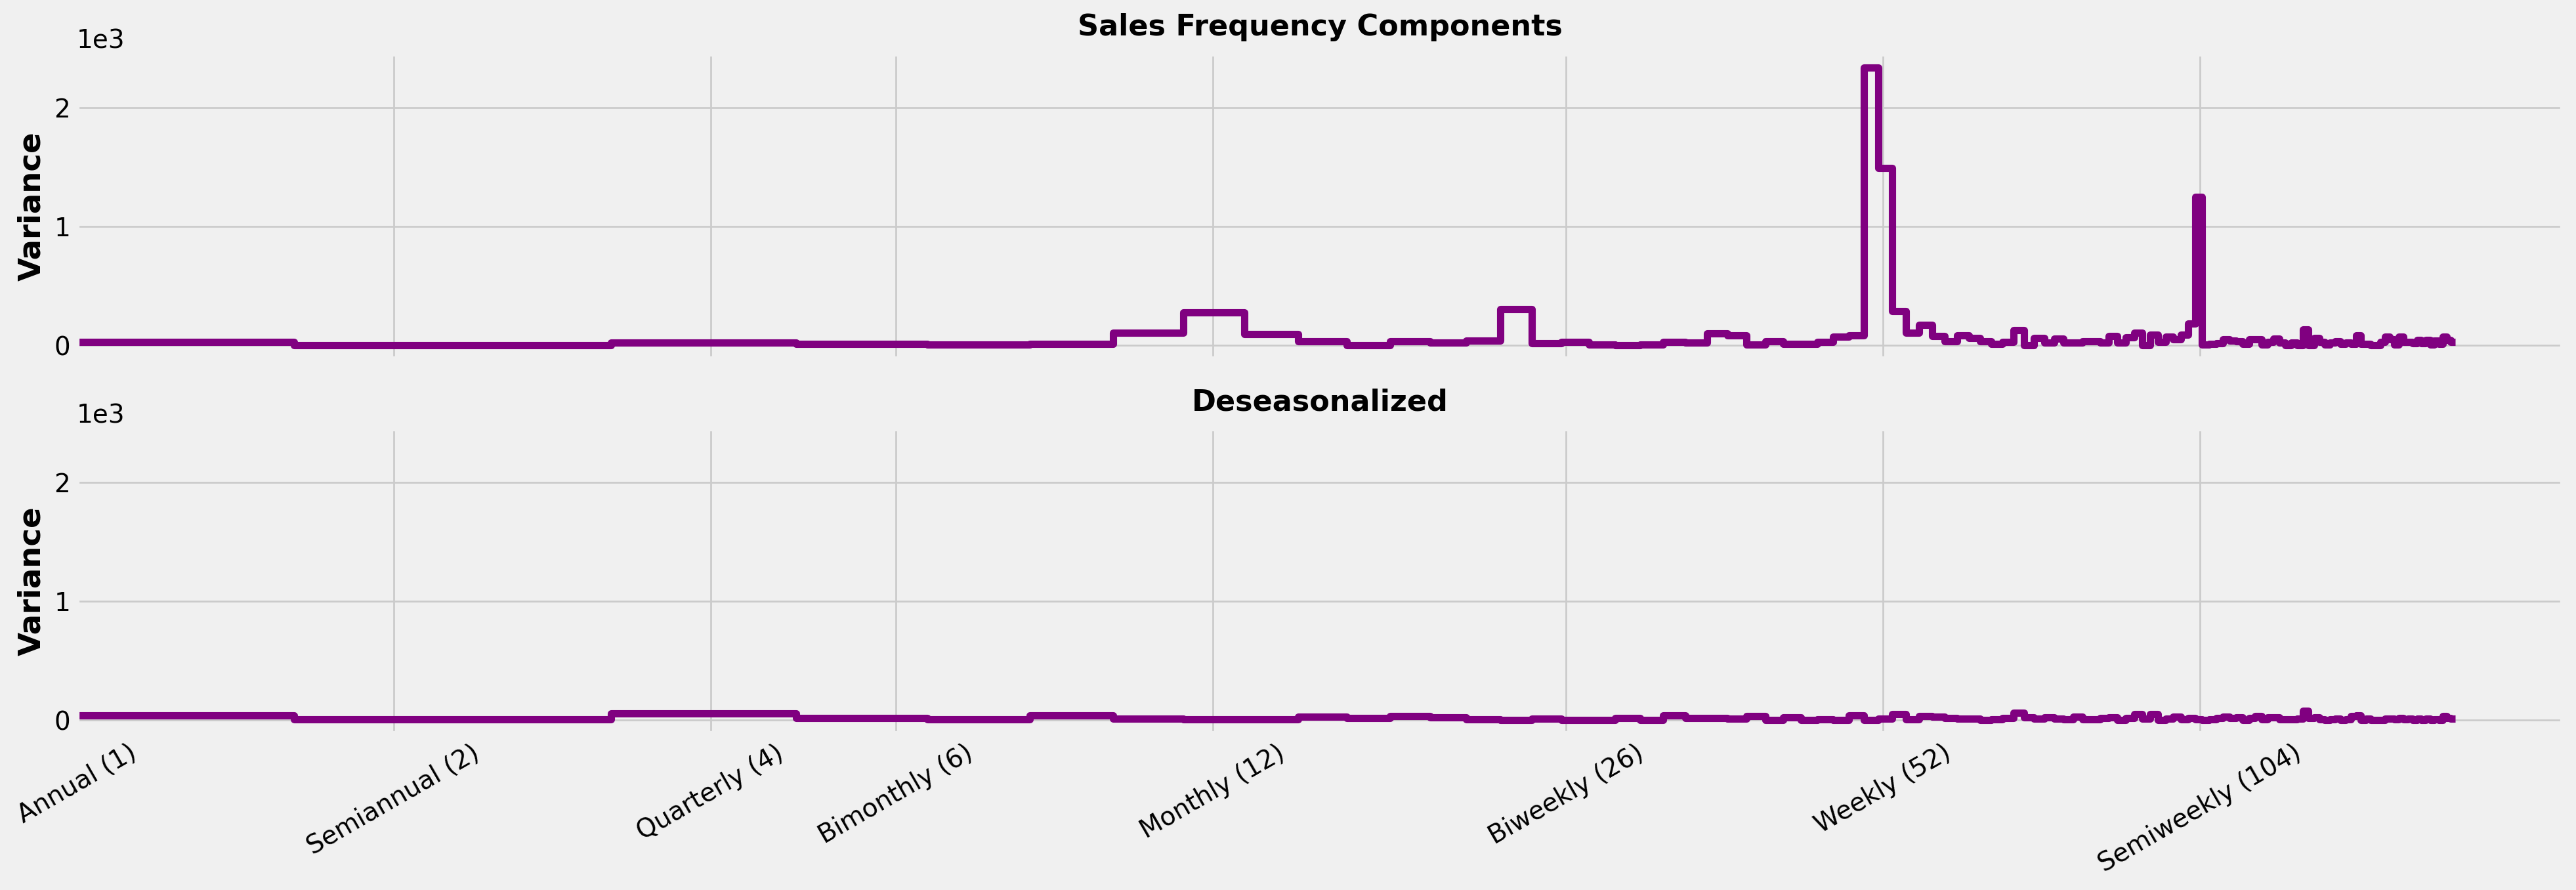

In [312]:
y_deseason = y - pd.concat([y_preds, y_fore])

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(20, 7))

plot_periodogram(y, ax=ax1)
ax1.set_title("Sales Frequency Components")
plot_periodogram(y_deseason, ax=ax2)
ax2.set_title("Deseasonalized");

Based on these periodograms, it appears the model effectively captured the seasonality in Average Sales. The periodogram for the deseasonalized series lacks any large values. By comparing it to the periodogram for the original series, we can see that our model was able to capture the seasonal variation in Average Sales.

In [ ]:
## evaluate performance

print("model performance with seasonal indicator and fourier features")
score_dataset(series=y, y_preds=y_preds, y_fore=y_fore)

model performance with seasonal indicator and fourier features
RMSLE:         0.08


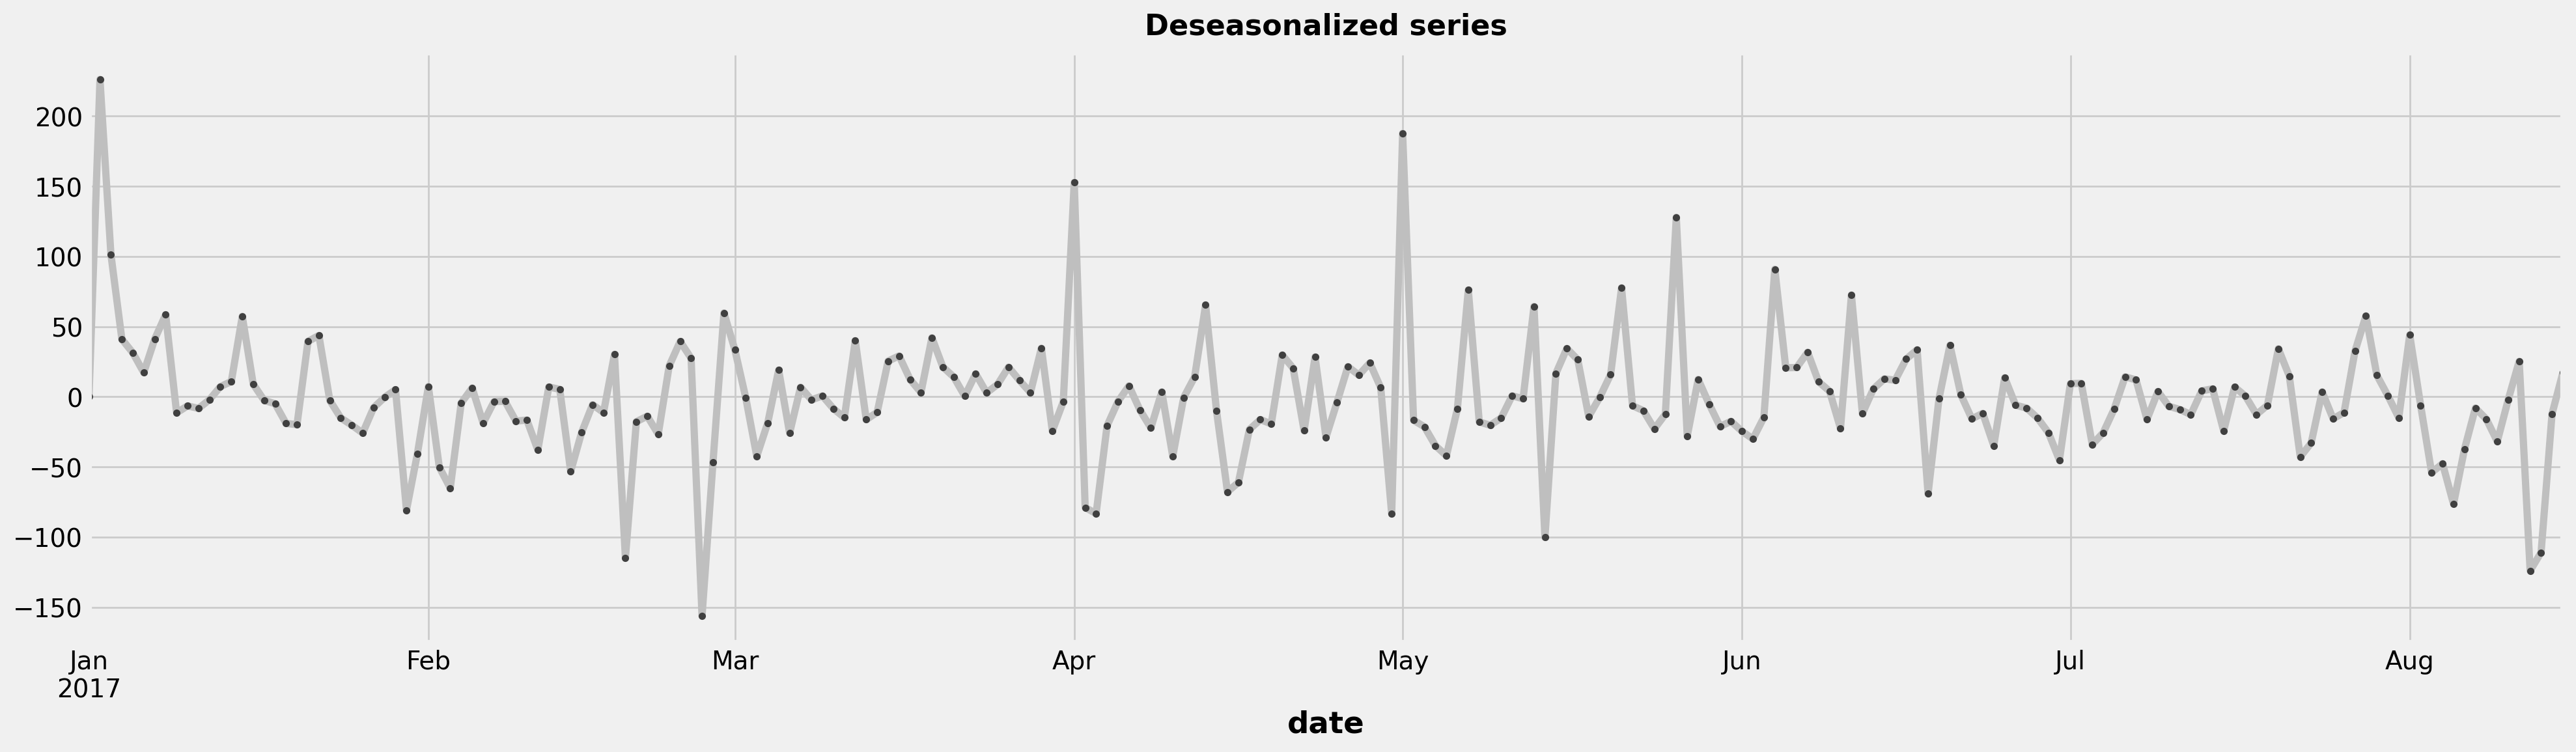

In [316]:
y_deseason.plot(**plot_params, title="Deseasonalized series");

- From the plot of the residuals, we see that the residuals aren't white noise yet. 
- We check for remaining seasonality
- The store sales dataset includes a table of Ecuadorian holidays

In [317]:
holidays = holiday_events.loc['2017-01-01':'2017-08-15', ["description"]]\
                        .assign(description= lambda x:x.description.cat.remove_unused_categories())  # remove unused categories to make one-hot encoding easy
              

oil_prices = oil.loc['2017-01-01':'2017-08-15']

In [318]:
## change DatetimeIndex to PeriodIndex for integration and plotting with average sales
holidays = holidays.to_period("D")
oil_prices = oil_prices.to_period("D")



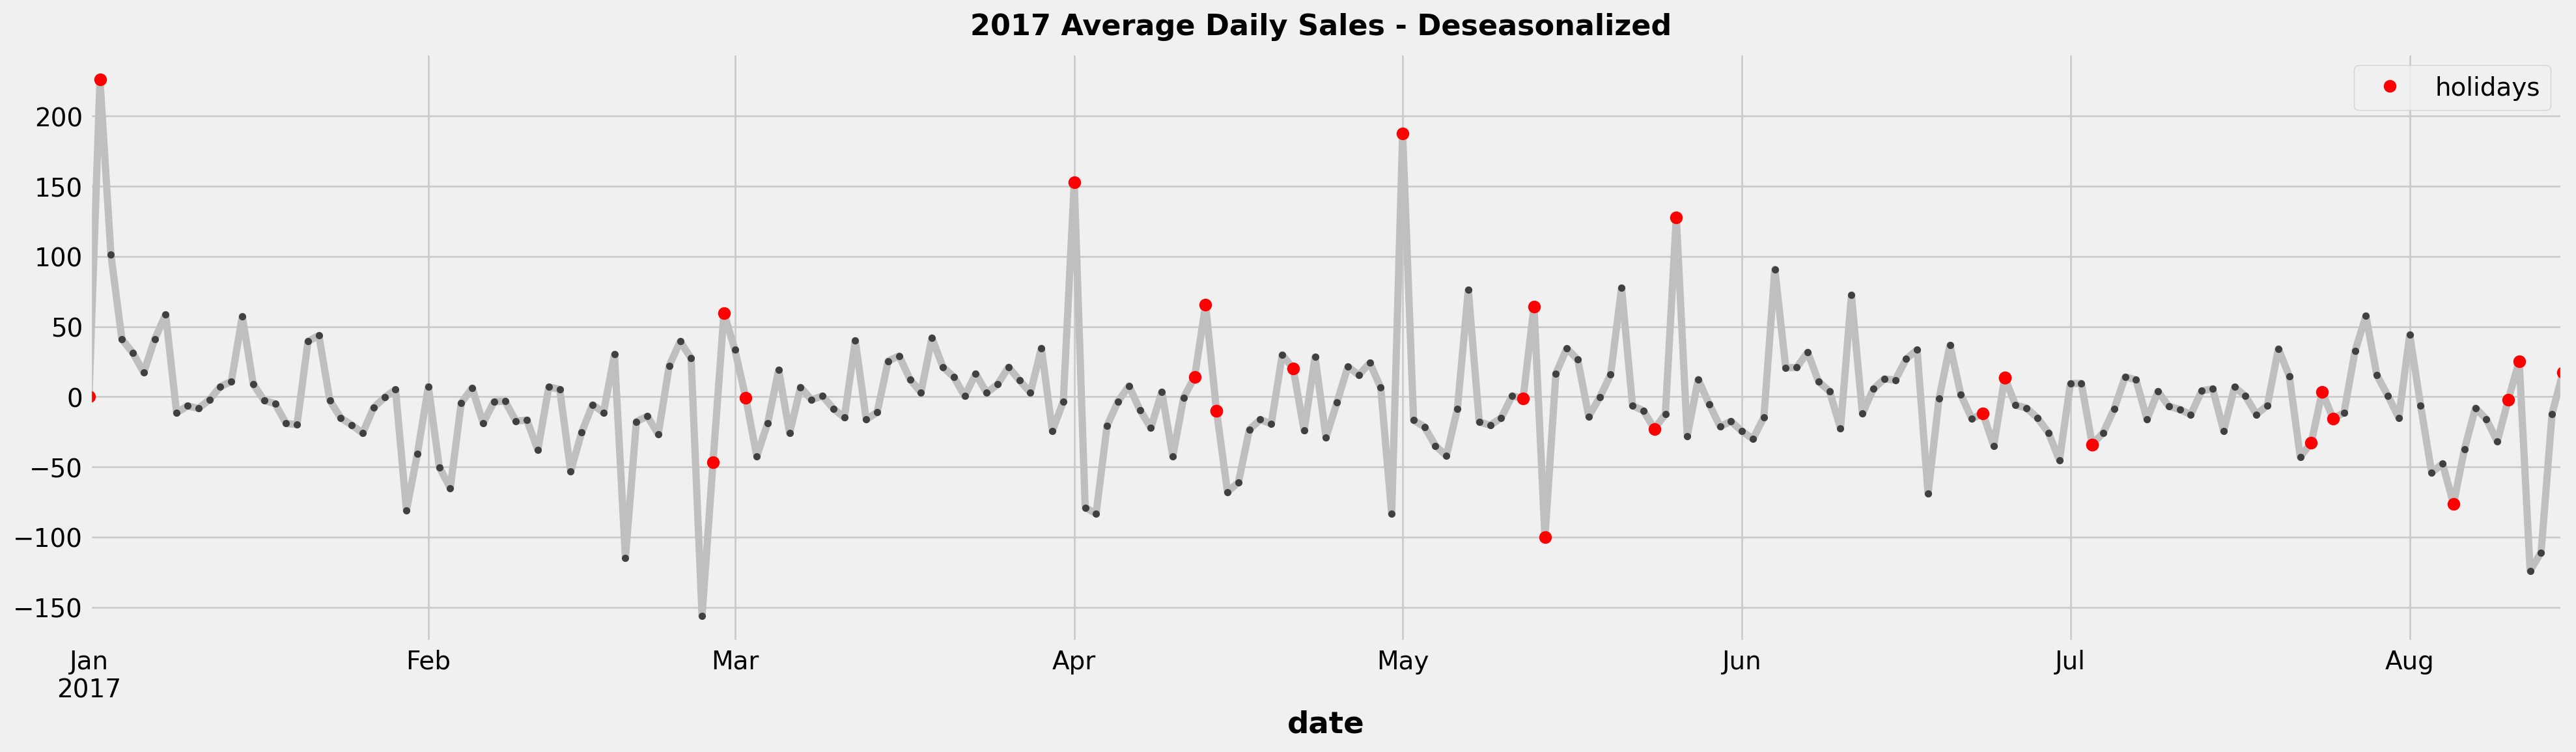

In [319]:
ax = y_deseason.plot(**plot_params)
plt.plot_date(holidays.index, y_deseason[holidays.index], color="red",  label="holidays")
ax.set_title("2017 Average Daily Sales - Deseasonalized ")
ax.legend();

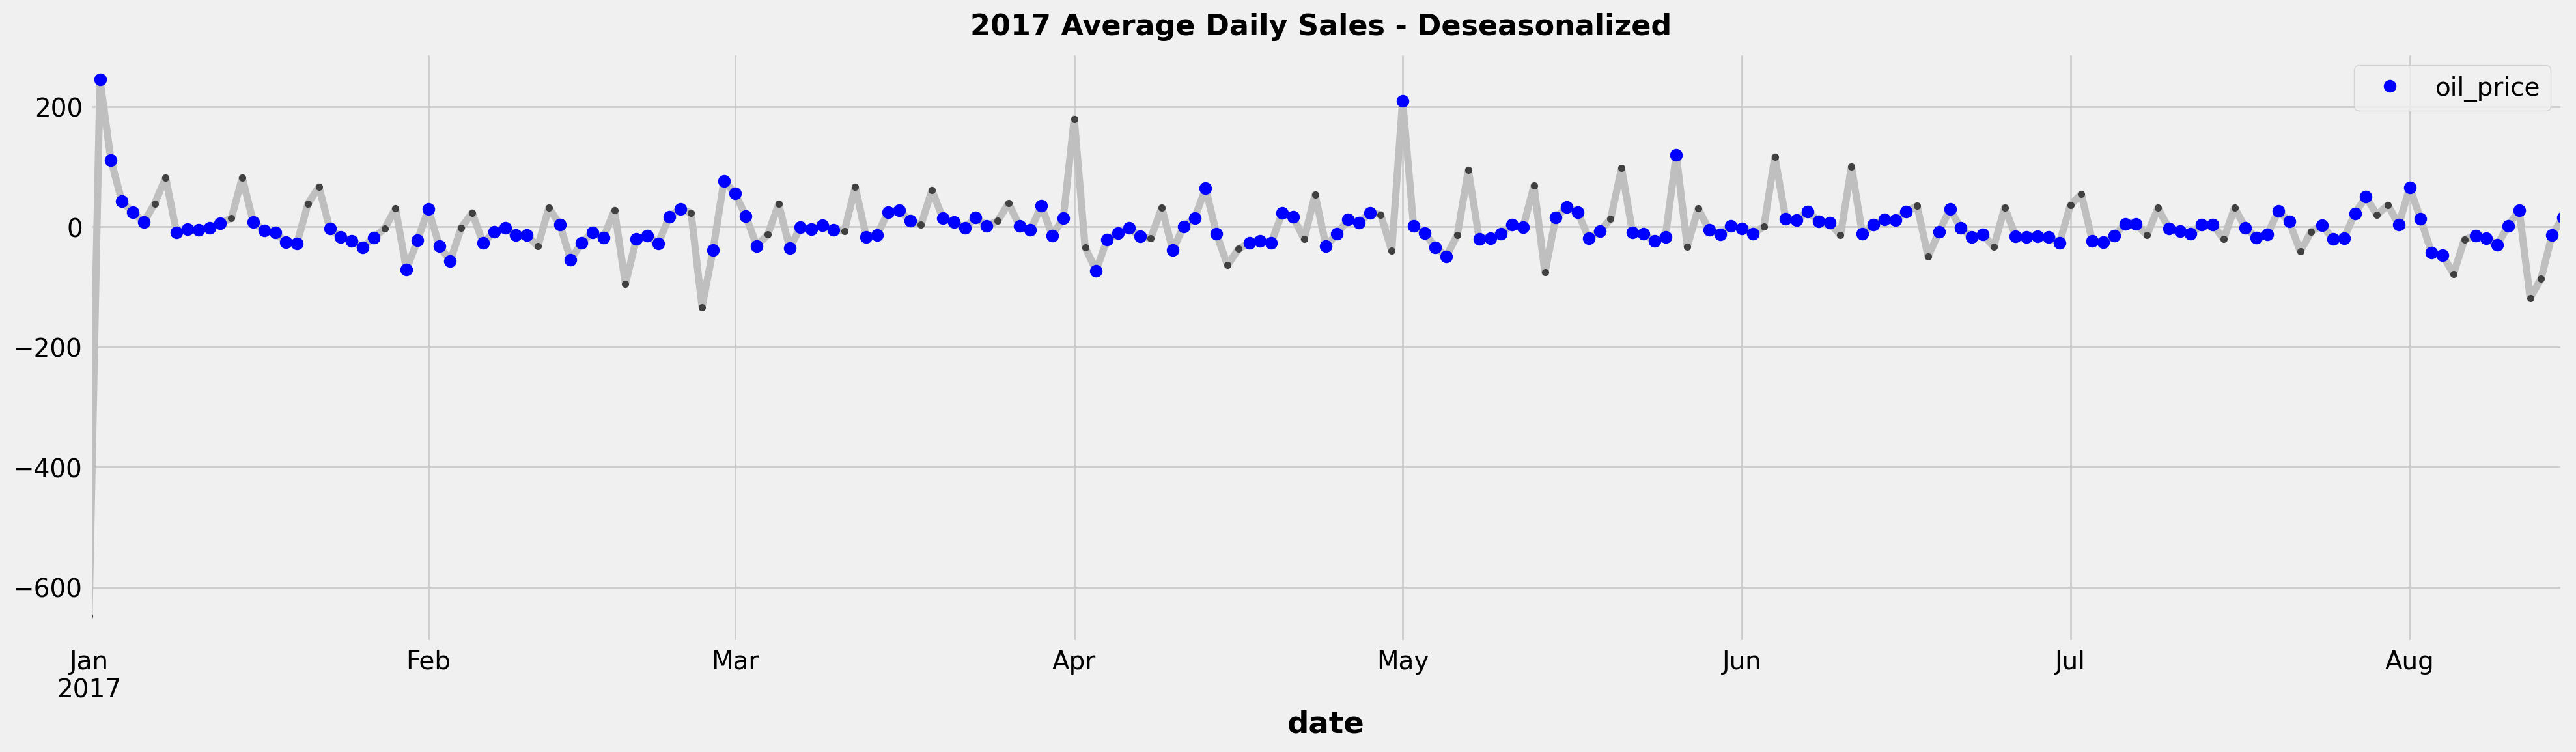

In [194]:
ax = y_deseason.plot(**plot_params)
ax.set_title("2017 Average Daily Sales - Deseasonalized ")
plt.plot_date(oil_prices.index, y_deseason[oil_prices.index], color="blue",  label="oil_price")
ax.legend();

- we see that sales spikes are likely explained by the holidays instead of the oil prices
- we'll create holiday features to help improve our model

### Create Holiday Features
create features to help model make use of this information 

In [213]:
## creaate one hot encoding of holidays description as categorical feature

ohe = OneHotEncoder(
    sparse_output=False, 
    handle_unknown="ignore",
)

X_holidays = pd.DataFrame(
    ohe.fit_transform(holidays),
    index=holidays.index,
    columns=ohe.get_feature_names_out()
)

X_holidays.head()

description_Batalla de Pichincha  \
date                                           
2017-01-01                               0.0   
2017-01-02                               0.0   
2017-02-27                               0.0   
2017-02-28                               0.0   
2017-03-02                               0.0   

            description_Cantonizacion de Cayambe  \
date                                               
2017-01-01                                   0.0   
2017-01-02                                   0.0   
2017-02-27                                   0.0   
2017-02-28                                   0.0   
2017-03-02                                   0.0   

            description_Cantonizacion de El Carmen  \
date                                                 
2017-01-01                                     0.0   
2017-01-02                                     0.0   
2017-02-27                                     0.0   
2017-02-28                                     0.0   
2017-03-02                                     0.0   

            description_Cantonizacion de Guaranda  \
date                                                
2017-01-01                                    0.0   
2017-01-02                                    0.0   
2017-02-27                                    0.0   
2017-02-28                                    0.0   
2017-03-02                                    0.0   

            description_Cantonizacion de Latacunga  \
date                                                 
2017-01-01                                     0.0   
2017-01-02                                     0.0   
2017-02-27                                     0.0   
2017-02-28                                     0.0   
2017-03-02                                     0.0   

            description_Cantonizacion de Libertad  \
date                                                
2017-01-01                                    0.0   
2017-01-02                                    0.0   
2017-02-27                                    0.0   
2017-02-28                                    0.0   
2017-03-02                                    0.0   

            description_Cantonizacion de Riobamba  \
date                                                
2017-01-01                                    0.0   
2017-01-02                                    0.0   
2017-02-27                                    0.0   
2017-02-28                                    0.0   
2017-03-02                                    0.0   

            description_Cantonizacion del Puyo  description_Carnaval  \
date                                                                   
2017-01-01                                 0.0                   0.0   
2017-01-02                                 0.0                   0.0   
2017-02-27                                 0.0                   1.0   
2017-02-28                                 0.0                   1.0   
2017-03-02                                 0.0                   0.0   

            description_Dia de la Madre  ...  \
date                                     ...   
2017-01-01                          0.0  ...   
2017-01-02                          0.0  ...   
2017-02-27                          0.0  ...   
2017-02-28                          0.0  ...   
2017-03-02                          0.0  ...   

            description_Fundacion de Riobamba  \
date                                            
2017-01-01                                0.0   
2017-01-02                                0.0   
2017-02-27                                0.0   
2017-02-28                                0.0   
2017-03-02                                0.0   

            description_Fundacion de Santo Domingo  \
date                                                 
2017-01-01                                     0.0   
2017-01-02                                     0.0   
2017-02-27                        

In [210]:
holidays.head()

description
date                                   
2017-01-01           Primer dia del ano
2017-01-02  Traslado Primer dia del ano
2017-02-27                     Carnaval
2017-02-28                     Carnaval
2017-03-02           Fundacion de Manta

In [211]:
X.head()

const  s(2,7)  s(3,7)  s(4,7)  s(5,7)  s(6,7)  s(7,7)  \
date                                                                
2017-01-01    1.0     0.0     0.0     0.0     0.0     0.0     0.0   
2017-01-02    1.0     1.0     0.0     0.0     0.0     0.0     0.0   
2017-01-03    1.0     0.0     1.0     0.0     0.0     0.0     0.0   
2017-01-04    1.0     0.0     0.0     1.0     0.0     0.0     0.0   
2017-01-05    1.0     0.0     0.0     0.0     1.0     0.0     0.0   

            sin(1,freq=M)  cos(1,freq=M)  sin(2,freq=M)  cos(2,freq=M)  \
date                                                                     
2017-01-01       0.000000       1.000000       0.000000       1.000000   
2017-01-02       0.201299       0.979530       0.394356       0.918958   
2017-01-03       0.394356       0.918958       0.724793       0.688967   
2017-01-04       0.571268       0.820763       0.937752       0.347305   
2017-01-05       0.724793       0.688967       0.998717      -0.050649   

            sin(3,freq=M)  cos(3,freq=M)  sin(4,freq=M)  cos(4,freq=M)  
date                                                                    
2017-01-01       0.000000       1.000000       0.000000       1.000000  
2017-01-02       0.571268       0.820763       0.724793       0.688967  
2017-01-03       0.937752       0.347305       0.998717      -0.050649  
2017-01-04       0.968077      -0.250653       0.651372      -0.758758  
2017-01-05       0.651372      -0.758758      -0.101168      -0.994869

In [218]:
X.merge(X_holidays, on="date", how="left")

const  s(2,7)  s(3,7)  s(4,7)  s(5,7)  s(6,7)  s(7,7)  \
date                                                                
2017-01-01    1.0     0.0     0.0     0.0     0.0     0.0     0.0   
2017-01-02    1.0     1.0     0.0     0.0     0.0     0.0     0.0   
2017-01-03    1.0     0.0     1.0     0.0     0.0     0.0     0.0   
2017-01-04    1.0     0.0     0.0     1.0     0.0     0.0     0.0   
2017-01-05    1.0     0.0     0.0     0.0     1.0     0.0     0.0   
...           ...     ...     ...     ...     ...     ...     ...   
2017-08-11    1.0     0.0     0.0     0.0     0.0     1.0     0.0   
2017-08-12    1.0     0.0     0.0     0.0     0.0     0.0     1.0   
2017-08-13    1.0     0.0     0.0     0.0     0.0     0.0     0.0   
2017-08-14    1.0     1.0     0.0     0.0     0.0     0.0     0.0   
2017-08-15    1.0     0.0     1.0     0.0     0.0     0.0     0.0   

            sin(1,freq=M)  cos(1,freq=M)  sin(2,freq=M)  ...  \
date                                                     ...   
2017-01-01       0.000000       1.000000       0.000000  ...   
2017-01-02       0.201299       0.979530       0.394356  ...   
2017-01-03       0.394356       0.918958       0.724793  ...   
2017-01-04       0.571268       0.820763       0.937752  ...   
2017-01-05       0.724793       0.688967       0.998717  ...   
...                   ...            ...            ...  ...   
2017-08-11       0.897805      -0.440394      -0.790776  ...   
2017-08-12       0.790776      -0.612106      -0.968077  ...   
2017-08-13       0.651372      -0.758758      -0.988468  ...   
2017-08-14       0.485302      -0.874347      -0.848644  ...   
2017-08-15       0.299363      -0.954139      -0.571268  ...   

            description_Fundacion de Riobamba  \
date                                            
2017-01-01                                0.0   
2017-01-02                                0.0   
2017-01-03                                NaN   
2017-01-04                                NaN   
2017-01-05                                NaN   
...                                       ...   
2017-08-11                                0.0   
2017-08-12                                NaN   
2017-08-13                                NaN   
2017-08-14                                NaN   
2017-08-15                                1.0   

            description_Fundacion de Santo Domingo  \
date                                                 
2017-01-01                                     0.0   
2017-01-02                                     0.0   
2017-01-03                                     NaN   
2017-01-04                                     NaN   
2017-01-05                                     NaN   
...                                            ...   
2017-08-11                                     0.0   
2017-08-12                                     NaN   
2017-08-13                                     NaN   
2017-08-14                                     NaN   
2017-08-15                                     0.0   

            description_Primer Grito de Independencia  \
date                                                    
2017-01-01                                        0.0   
2017-01-02                                        0.0   
2017-01-03                                        NaN   
2017-01-04                                        NaN   
2017-01-05                                        NaN   
...                                               ...   
2017-08-11                                        0.0   
2017-08-12                                        NaN   
2017-08-13                                        NaN   
2017-08-14                                        NaN   
2017-08-15                                        0.0   

            description_Primer dia del ano  \
date                                         
2017-01-01                             1.0   
2017-01-02                             0.0   
2017-01-03    

In [219]:
X_eval.head()

const  s(2,7)  s(3,7)  s(4,7)  s(5,7)  s(6,7)  s(7,7)  \
date                                                                
2017-07-01    1.0     0.0     0.0     0.0     0.0     0.0     0.0   
2017-07-02    1.0     1.0     0.0     0.0     0.0     0.0     0.0   
2017-07-03    1.0     0.0     1.0     0.0     0.0     0.0     0.0   
2017-07-04    1.0     0.0     0.0     1.0     0.0     0.0     0.0   
2017-07-05    1.0     0.0     0.0     0.0     1.0     0.0     0.0   

            sin(1,freq=M)  cos(1,freq=M)  sin(2,freq=M)  cos(2,freq=M)  \
date                                                                     
2017-07-01       0.000000       1.000000       0.000000       1.000000   
2017-07-02       0.201299       0.979530       0.394356       0.918958   
2017-07-03       0.394356       0.918958       0.724793       0.688967   
2017-07-04       0.571268       0.820763       0.937752       0.347305   
2017-07-05       0.724793       0.688967       0.998717      -0.050649   

            sin(3,freq=M)  cos(3,freq=M)  sin(4,freq=M)  cos(4,freq=M)  
date                                                                    
2017-07-01       0.000000       1.000000       0.000000       1.000000  
2017-07-02       0.571268       0.820763       0.724793       0.688967  
2017-07-03       0.937752       0.347305       0.998717      -0.050649  
2017-07-04       0.968077      -0.250653       0.651372      -0.758758  
2017-07-05       0.651372      -0.758758      -0.101168      -0.994869